## Início

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import joblib
import pickle

In [4]:
import shap

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.set_option("styler.format.thousands", ",")
pd.options.display.float_format = "{:,.2f}".format

In [10]:
%matplotlib inline
%xmode plain
%config InlineBackend.figure_format='retina'

Exception reporting mode: Plain


In [11]:
import session_info
session_info.show()

---

## Construindo o DataFrame `results`

In [12]:
import os

In [13]:
model_files = [f for f in os.listdir("models/") if f.endswith(".pkl")]

['model_lgbm.pkl',
 'model_rf.pkl',
 'model_logreg.pkl',
 'model_sgd.pkl',
 'model_svm.pkl',
 'model_tabnet.pkl',
 'model_xgb.pkl',
 'model_mlp.pkl']

In [14]:
loaded_models = []
print(f"📂 Encontrados {len(model_files)} modelos para carregar.\n")

📂 Encontrados 8 modelos para carregar.



In [ ]:
for model_file in model_files:
    start_time = time.time()
    print(f"⏳ Carregando {model_file}...")
    model = joblib.load(os.path.join("models/", model_file))
    loaded_models.append(model)
    elapsed_time = time.time() - start_time
    print(f"✅ {model_file} carregado com sucesso! ({elapsed_time:.2f} segundos)\n")
print(f"✅ Todos modelos carregados ({len(loaded_models)}/{len(model_files)}).")

⏳ Carregando model_lgbm.pkl...
✅ model_lgbm.pkl carregado com sucesso! (1.65 segundos)

⏳ Carregando model_rf.pkl...


In [ ]:
df_results = pd.DataFrame(loaded_models).set_index("model");

In [ ]:
name_mapping = {
    "LogisticRegression": "Regressão Logística",
    "RandomForestClassifier": "Random Forest",
    "XGBClassifier": "XGBoost",
    "LGBMClassifier": "LightGBM",
    "MLPClassifier": "MLP",
    "TabNetClassifier": "TabNet",
    "LinearSVC": "SVM (Linear)",
    "SGDClassifier": "SGD"
};

In [ ]:
df_results = df_results.rename(index=name_mapping)

---

## Salvando em Disco o `results`

In [ ]:
# arquivo com os modelos ficaria muito grande
df_results = df_results.drop("pipeline", axis=1);

In [ ]:
df_results.to_pickle("./df_results.pkl")

---

## Modificando o *dataset* para binário

In [15]:
df_combined = pd.read_pickle('./pickles/df_combined.pkl')
binary_label_series = df_combined["label"].apply(lambda x: "benign" if x == "benign" else "attack")
label_counts = binary_label_series.value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100
label_summary = pd.DataFrame({
    'Quantidade': label_counts.apply(lambda x: f"{x:,}"),
    'Proporção (%)': label_percentages.round(1).astype(str)
})

Quantidade Proporção (%)
label                          
attack  1,214,848          52.5
benign  1,098,126          47.5

In [16]:
df_binary = df_combined
df_binary["label"] = binary_label_series

In [17]:
pd.to_pickle(df_binary, "./df_binary.pkl")

A classe positiva (de interesse) são os ataques, então será a classe `1`

## Treino/Teste Binário

In [18]:
X_binary = df_binary.drop(columns=['label'])
y_binary = df_binary['label']
y_binary = y_binary.map({"benign": 0, "attack": 1})

X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

## XGBoost Binário

In [19]:
import time
from xgboost import XGBClassifier

In [20]:
model = XGBClassifier(eval_metric="logloss", enable_categorical=True, random_state=42)

start_train = time.time()
model.fit(X_binary_train, y_binary_train)
end_train = time.time()

train_time = end_train - start_train
print(f"Tempo de Treino: {train_time:,.2f}s")

Tempo de Treino: 52.77s


In [21]:
start_test = time.time()
y_binary_pred = model.predict(X_binary_test)
end_test = time.time()
test_time = end_test - start_test
print(f"Tempo de Teste: {test_time:,.2f}s")

Tempo de Teste: 0.73s


---

## Resultados XGBoost Binário

In [22]:
accuracy = accuracy_score(y_binary_test, y_binary_pred)
precision = precision_score(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred)
f1 = f1_score(y_binary_test, y_binary_pred)

metrics_df = pd.DataFrame(
    {
        "Métrica": ["Tempo de Treino", "Tempo de Teste", "Acurácia", "Precisão", "Revocação", "Escore F1"],
        "Resultado": [
            f"{train_time:.2f}s",
            f"{test_time:.2f}s",
            f"{accuracy * 100:.1f}%",
            f"{precision * 100:.1f}%",
            f"{recall * 100:.1f}%",
            f"{f1 * 100:.1f}%",                
        ],
    }
)

Métrica Resultado
0  Tempo de Treino    52.77s
1   Tempo de Teste     0.73s
2         Acurácia     86.1%
3         Precisão     87.8%
4        Revocação     85.4%
5        Escore F1     86.6%

Os resultados, ao restringirmo-nos a somente duas classes, são consideravelmente melhores

---

## Salvando em Disco o XGBoost Binário

In [23]:
joblib.dump(model, "model_xgb_binary.pkl")

['model_xgb_binary.pkl']

---

## Refinando o DF `results`

In [24]:
df_results = pd.read_pickle("df_results.pkl");

In [25]:
df_results = df_results.sort_values(by="recall", ascending=True)
cols = ["accuracy", "precision", "recall", "f1", "train_time", "test_time", "confusion_matrix", "predictions"]
df_results = df_results[cols];

In [26]:
df_results = df_results.rename(
    columns={
        "accuracy": "Acurácia (%)",
        "precision": "Precisão (%)",
        "recall": "Revocação (%)",
        "f1": "Escore F1 (%)",
        "train_time": "Tempo de Treino (s)",
        "test_time": "Tempo de Teste (s)",
        "confusion_matrix": "Matriz de Confusão",
        "predictions": "Predições",
    }
);

In [27]:
# converte em porcentagem
df_results[["Acurácia (%)", "Precisão (%)", "Revocação (%)", "Escore F1 (%)"]] = (
    df_results[["Acurácia (%)", "Precisão (%)", "Revocação (%)", "Escore F1 (%)"]] * 100
)
# uma casa decimal apenas
df_results[["Acurácia (%)", "Precisão (%)", "Revocação (%)", "Escore F1 (%)"]] = df_results[
    ["Acurácia (%)", "Precisão (%)", "Revocação (%)", "Escore F1 (%)"]
].applymap(lambda x: f"{x:.1f}")

In [28]:
df_results

Acurácia (%) Precisão (%) Revocação (%) Escore F1 (%)  \
model                                                                       
MLP                         51.1         15.3          10.8           8.8   
Regressão Logística         24.8          7.3          11.6           6.3   
SGD                         24.4         11.7          14.4           8.5   
SVM (Linear)                36.0         16.8          19.3          14.0   
TabNet                      72.2         56.7          31.8          35.0   
LightGBM                    75.7         46.7          36.5          40.0   
Random Forest               76.8         58.9          36.6          41.1   
XGBoost                     77.1         67.2          37.7          43.3   

                     Tempo de Treino (s)  Tempo de Teste (s)  \
model                                                          
MLP                               225.97                7.21   
Regressão Logística               539.10                0.35   
SGD                               244.97                0.36   
SVM (Linear)                      871.56                0.34   
TabNet                          4,285.87                7.79   
LightGBM                           55.14               10.11   
Random Forest                     318.24               23.48   
XGBoost                           102.97                3.05   

                                                    Matriz de Confusão  \
model                                                                    
MLP                  [[0, 754, 0, 0, 0, 0, 0, 0, 0, 0, 211, 0], [0,...   
Regressão Logística  [[0, 13, 10322, 40966, 0, 0, 43852, 0, 0, 0, 0...   
SGD                  [[15654, 24200, 32766, 629, 4597, 909, 130, 13...   
SVM (Linear)         [[12, 168, 2, 77, 34, 46, 9, 101, 28, 368, 109...   
TabNet               [[0, 476, 0, 12, 0, 1, 87, 8, 0, 0, 381, 0], [...   
LightGBM             [[80, 353, 3, 36, 1, 3, 56, 93, 1, 12, 307, 20...   
Random Forest        [[50431, 260, 28044, 1118, 15161, 11, 6, 53, 5...   
XGBoost              [[75, 362, 0, 30, 0, 5, 56, 105, 1, 1, 314, 16...   

                                                             Predições  
model                                                                   
MLP                  [1, 10, 1, 1, 10, 10, 1, 1, 10, 1, 10, 1, 1, 1...  
Regressão Logística  [command_injection, command_injection, mitm_ar...  
SGD                  [recon, vulnerability_scan, dns_spoofing, dns_...  
SVM (Linear)         [9, 8, 1, 7, 10, 8, 10, 9, 9, 5, 7, 1, 1, 3, 1...  
TabNet               [10, 10, 1, 10, 10, 10, 1, 10, 7, 1, 7, 1, 1, ...  
LightGBM             [1, 10, 1, 10, 10, 10, 1, 1, 7, 1, 7, 1, 1, 1,...  
Random Forest        [benign, vulnerability_scan, benign, vulnerabi...  
XGBoost              [1, 10, 1, 10, 10, 10, 1, 10, 7, 1, 7, 1, 1, 1...

---

## Salvando em Disco `results` tratado

In [29]:
df_results.to_pickle("./df_results_formatted.pkl")

---

## Recursos de Explicações

- [SHAP - Aidan Cooper](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)
- [SHAP - Official Docs - Classification with XGBoost](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html)
- [SHAP - Datacamp - Main Plot Types](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)
- [SHAP - `shapash`](https://github.com/MAIF/shapash)

---

## Explicações Binário

In [30]:
df_binary    = pd.read_pickle("./df_binary.pkl")
binary_model = joblib.load("model_xgb_binary.pkl");

In [31]:
print(f"""
{len(df_binary) = :,}
""")


len(df_binary) = 2,312,974



In [32]:
X_binary = df_binary.drop(columns=['label'])
y_binary = df_binary['label'].map({"benign": 0, "attack": 1})

X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(
    X_binary, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

In [33]:
print(f"""
{len(X_binary_train) = :,}
{len(y_binary_train) = :,}

{len(X_binary_test)  = :,}
{len(y_binary_test)  = :,}
""")


len(X_binary_train) = 1,619,081
len(y_binary_train) = 1,619,081

len(X_binary_test)  = 693,893
len(y_binary_test)  = 693,893



In [34]:
y_binary_map = {"benign": 0, "attack": 1};

In [35]:
y_binary_pred = binary_model.predict(X_binary_test)

array([1, 1, 0, ..., 0, 0, 0])

> **_CUIDADO_**: Operação abaixo computacionalmente cara, vamos serializar para não esperar no futuro

In [ ]:
shap_explainer_binary = shap.TreeExplainer(binary_model)
shap_values_binary    = shap_explainer_binary.shap_values(X_binary_test);

In [ ]:
joblib.dump(shap_explainer_binary, './shap_explainer_binary.pkl')

In [ ]:
joblib.dump(shap_values_binary, './shap_values_binary.pkl')

---

### Importância Global

Carregando os objetos salvos:

In [36]:
shap_explainer_binary = joblib.load('./shap_explainer_binary.pkl')
shap_values_binary    = joblib.load('./shap_values_binary.pkl');

💡 Intuition: SHAP values measure how much a feature contributes to the final prediction, averaged over all possible feature combinations.

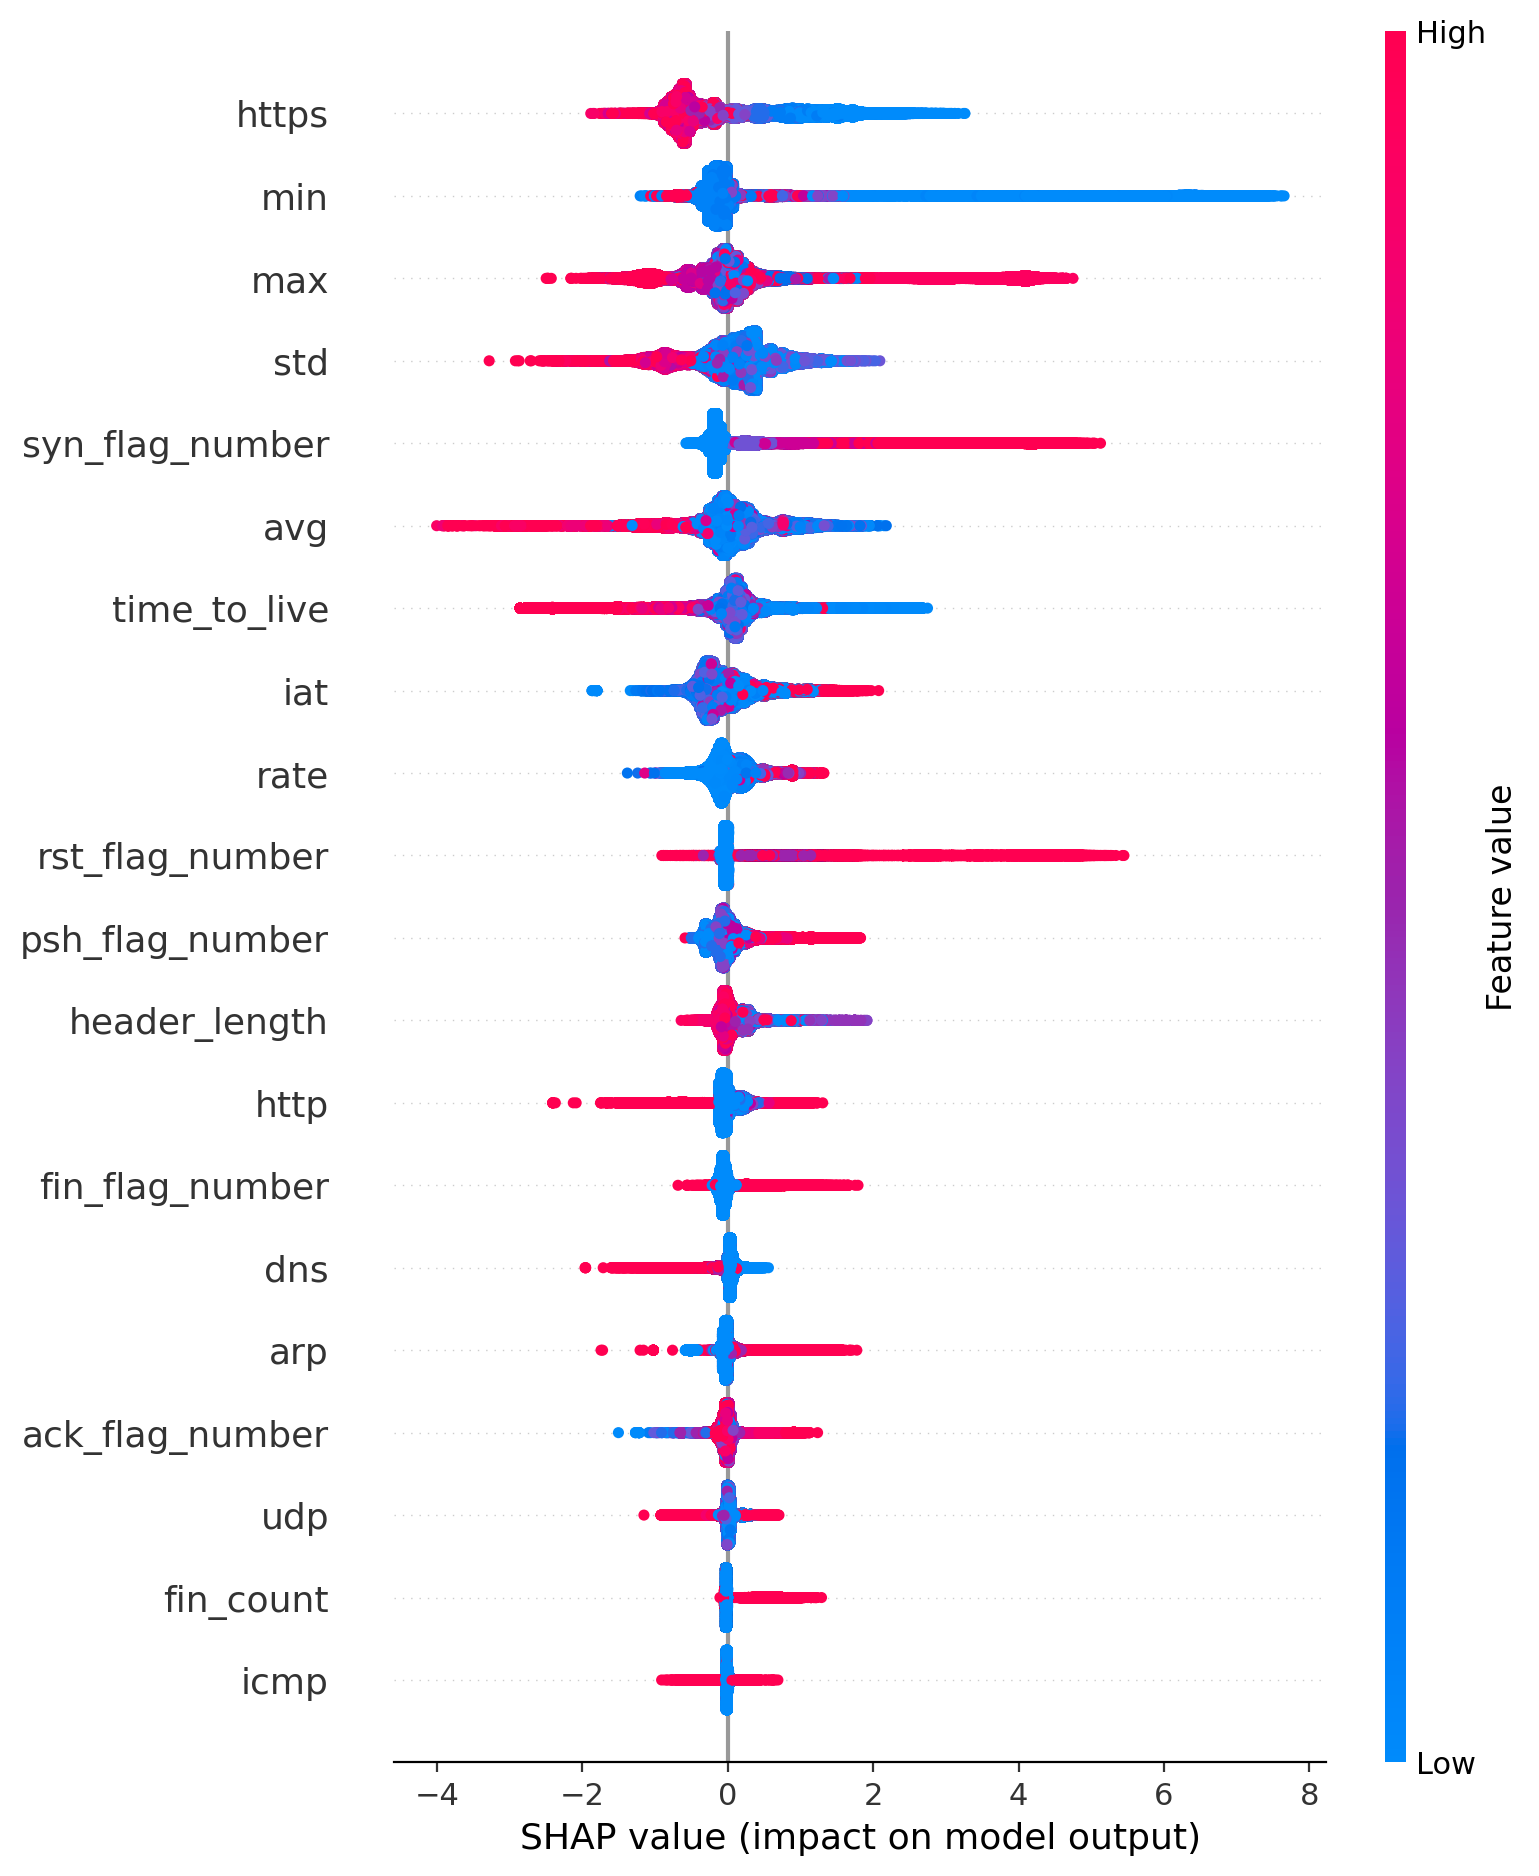

In [37]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_binary, X_binary_test)

1. Amplitude horizontal pode indicar impacto diferente a depender de outras *features* $\rightarrow$ Muitos atributos podem conter não-linearidade.
2. Atributos que tendenciam a predução para uma classe, isto é, com $|SHAP| \geq 3$:
    - Ataque (Classe 1): `https`, `min`, `max`, `syn_flag_number`, `rst_flag_number`
    - Normal (Classe 0): `std`, `avg`, `time_to_live`

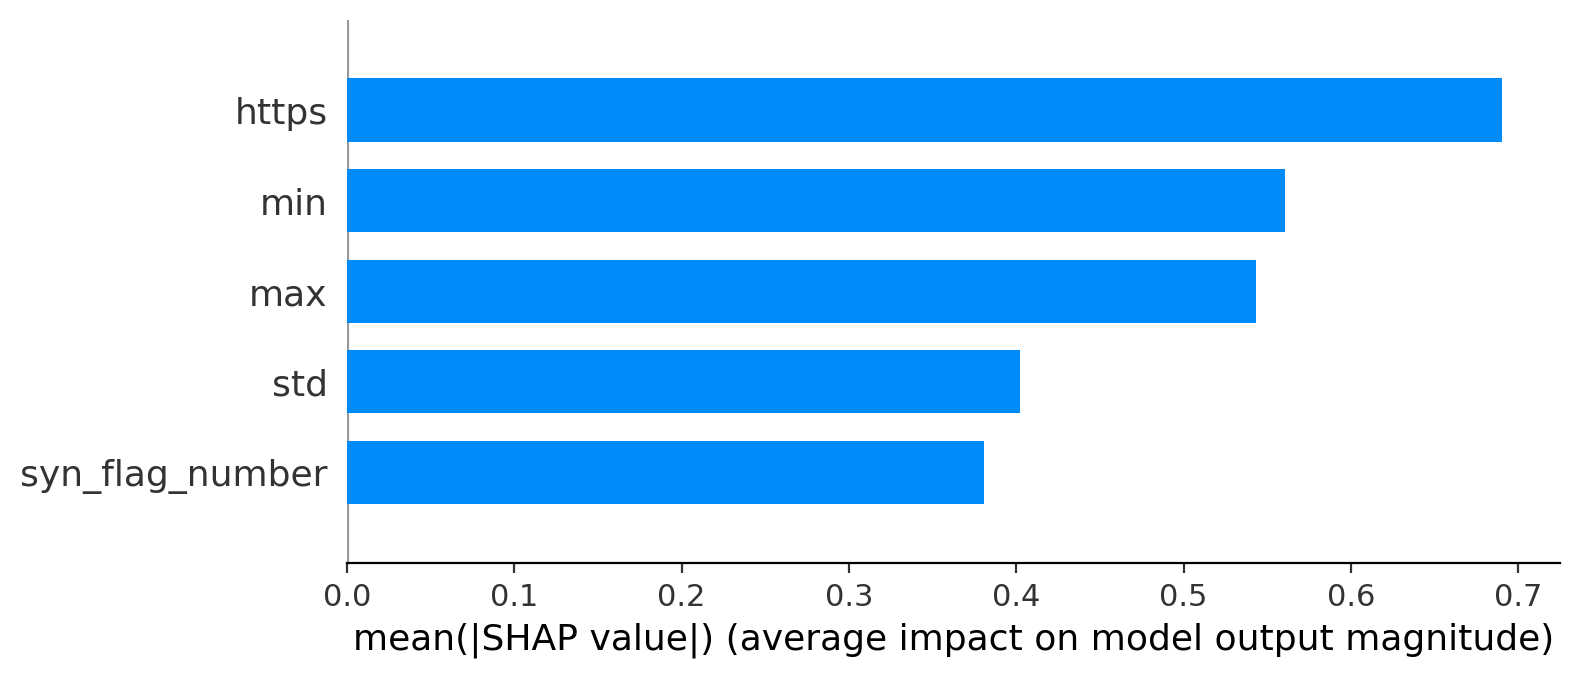

In [38]:
shap.summary_plot(shap_values_binary, X_binary_test, plot_type="bar", max_display=5)

1. Confirmando as conclusões acima, as *features* com maior impacto, em valor absoluto, são `https`, `syn_flag_numer`, e as features estatísticas

### Seleção de Instâncias

1. Casos próximos da fronteira de decisão

In [39]:
y_pred_proba = binary_model.predict_proba(X_binary_test)[:, 1]
# Obtenha as predições (limiar padrão de 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)
# Converta o rótulo real para array
y_true = y_binary_test.values
# Calcule a distância de cada instância à fronteira (0.5)
distance_to_boundary = np.abs(y_pred_proba - 0.5)
# Ordene os índices pelo menor valor de distância (mais próximo de 0.5)
sorted_indices = np.argsort(distance_to_boundary)
# Seleção: para cada classe prevista (0 e 1), escolha 2 instâncias
boundary_indices_class0 = []
boundary_indices_class1 = []

for idx in sorted_indices:
    if y_pred[idx] == 0 and len(boundary_indices_class0) < 2:
        boundary_indices_class0.append(idx)
    elif y_pred[idx] == 1 and len(boundary_indices_class1) < 2:
        boundary_indices_class1.append(idx)
    if len(boundary_indices_class0) == 2 and len(boundary_indices_class1) == 2:
        break

boundary_indices_class0 = list(map(int, boundary_indices_class0))
boundary_indices_class1 = list(map(int, boundary_indices_class1))
print("Índices próximos à fronteira para predições 0:", boundary_indices_class0)
print("Índices próximos à fronteira para predições 1:", boundary_indices_class1)

Índices próximos à fronteira para predições 0: [242602, 158076]
Índices próximos à fronteira para predições 1: [418143, 570319]


2. Casos de decisão confiante porém errada

In [40]:
# Identifique os índices onde o modelo errou
misclassified_idx = np.where(y_pred != y_true)[0]
# Ordene estes índices pelo valor da distância à fronteira (do maior para o menor)
sorted_misclassified_idx = misclassified_idx[np.argsort(-distance_to_boundary[misclassified_idx])]

misclassified_indices_class0 = []  # onde o modelo previu 0 (errado)
misclassified_indices_class1 = []  # onde o modelo previu 1 (errado)

for idx in sorted_misclassified_idx:
    if y_pred[idx] == 0 and len(misclassified_indices_class0) < 2:
        misclassified_indices_class0.append(idx)
    elif y_pred[idx] == 1 and len(misclassified_indices_class1) < 2:
        misclassified_indices_class1.append(idx)
    if len(misclassified_indices_class0) == 2 and len(misclassified_indices_class1) == 2:
        break

misclassified_indices_class0 = list(map(int, misclassified_indices_class0))
misclassified_indices_class1 = list(map(int, misclassified_indices_class1))
print("Índices de predições erradas (modelo previu 0) com alta confiança:", misclassified_indices_class0)
print("Índices de predições erradas (modelo previu 1) com alta confiança:", misclassified_indices_class1)

Índices de predições erradas (modelo previu 0) com alta confiança: [595190, 5187]
Índices de predições erradas (modelo previu 1) com alta confiança: [155140, 517138]


---

### Importância Local

In [41]:
log_odd_base_value = shap_explainer_binary.expected_value
p = f"Probabilidade base de chute do modelo = {float(1 / (1 + np.exp(-log_odd_base_value))):,.2f}%"

'Probabilidade base de chute do modelo = 0.54%'

> **_Lembrete:_** Para um modelo binário, a decisão é baseada na probabilidade de classe 1

índices com instâncias interessantes:

In [42]:
print(boundary_indices_class0, boundary_indices_class1)
print(misclassified_indices_class0, misclassified_indices_class1)

[242602, 158076] [418143, 570319]
[595190, 5187] [155140, 517138]


In [43]:
X_binary_test = X_binary_test.round(2);

#### Force

> Piores Classificações

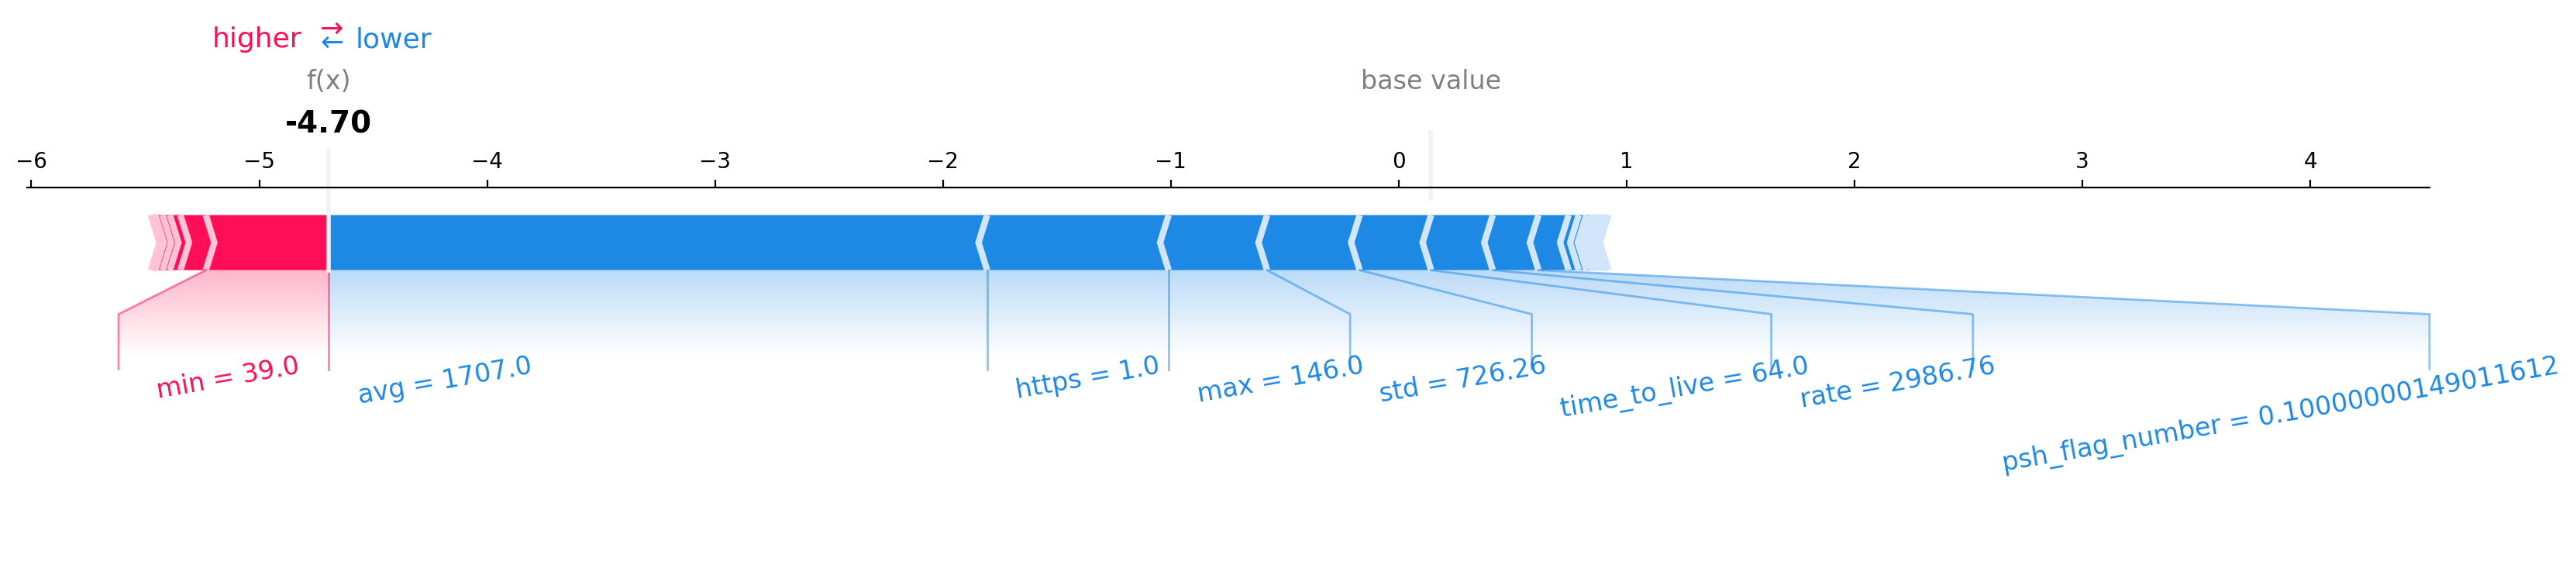

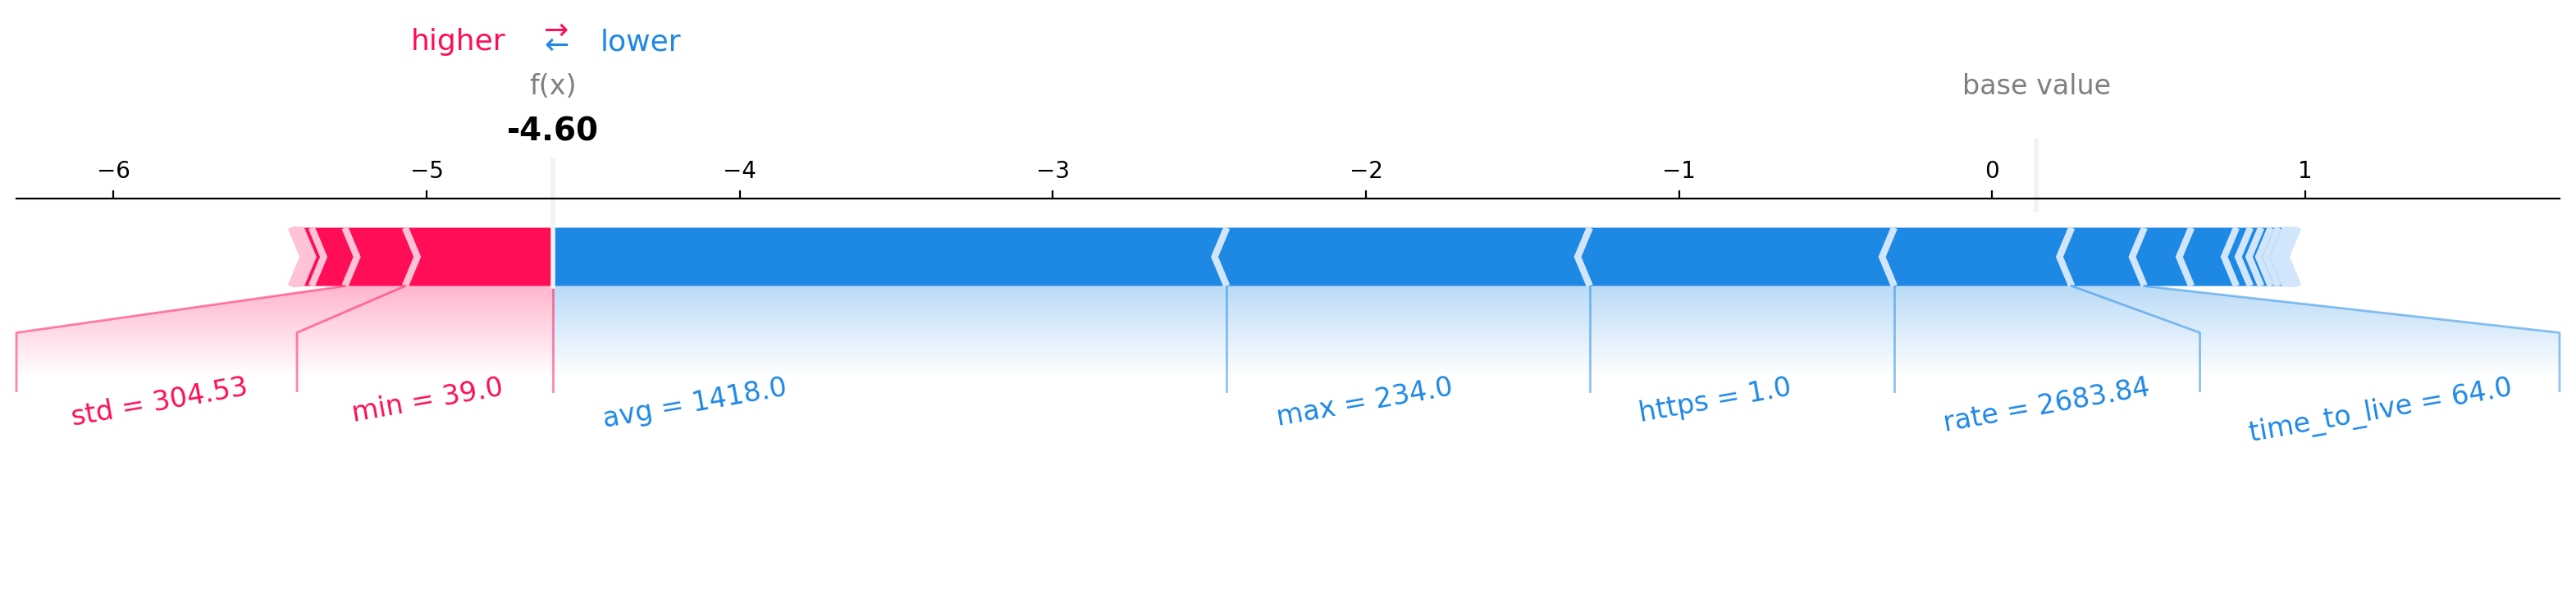

In [44]:
for idx in misclassified_indices_class0:
    shap.initjs()
    shap.force_plot(shap_explainer_binary.expected_value, shap_values_binary[idx], X_binary_test.iloc[idx], matplotlib=True, text_rotation=10)

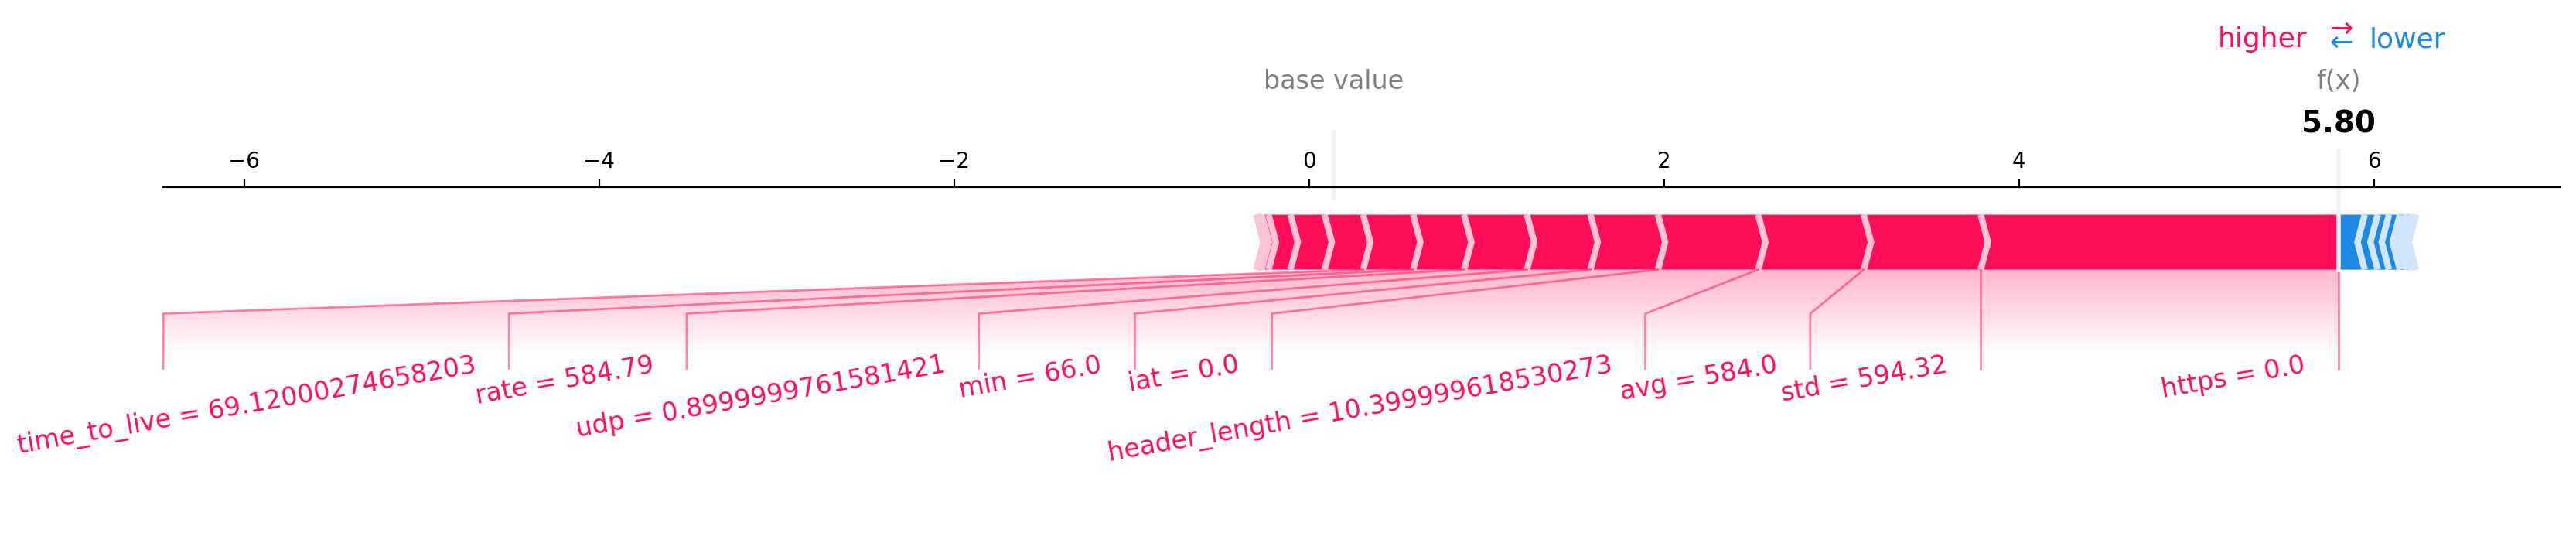

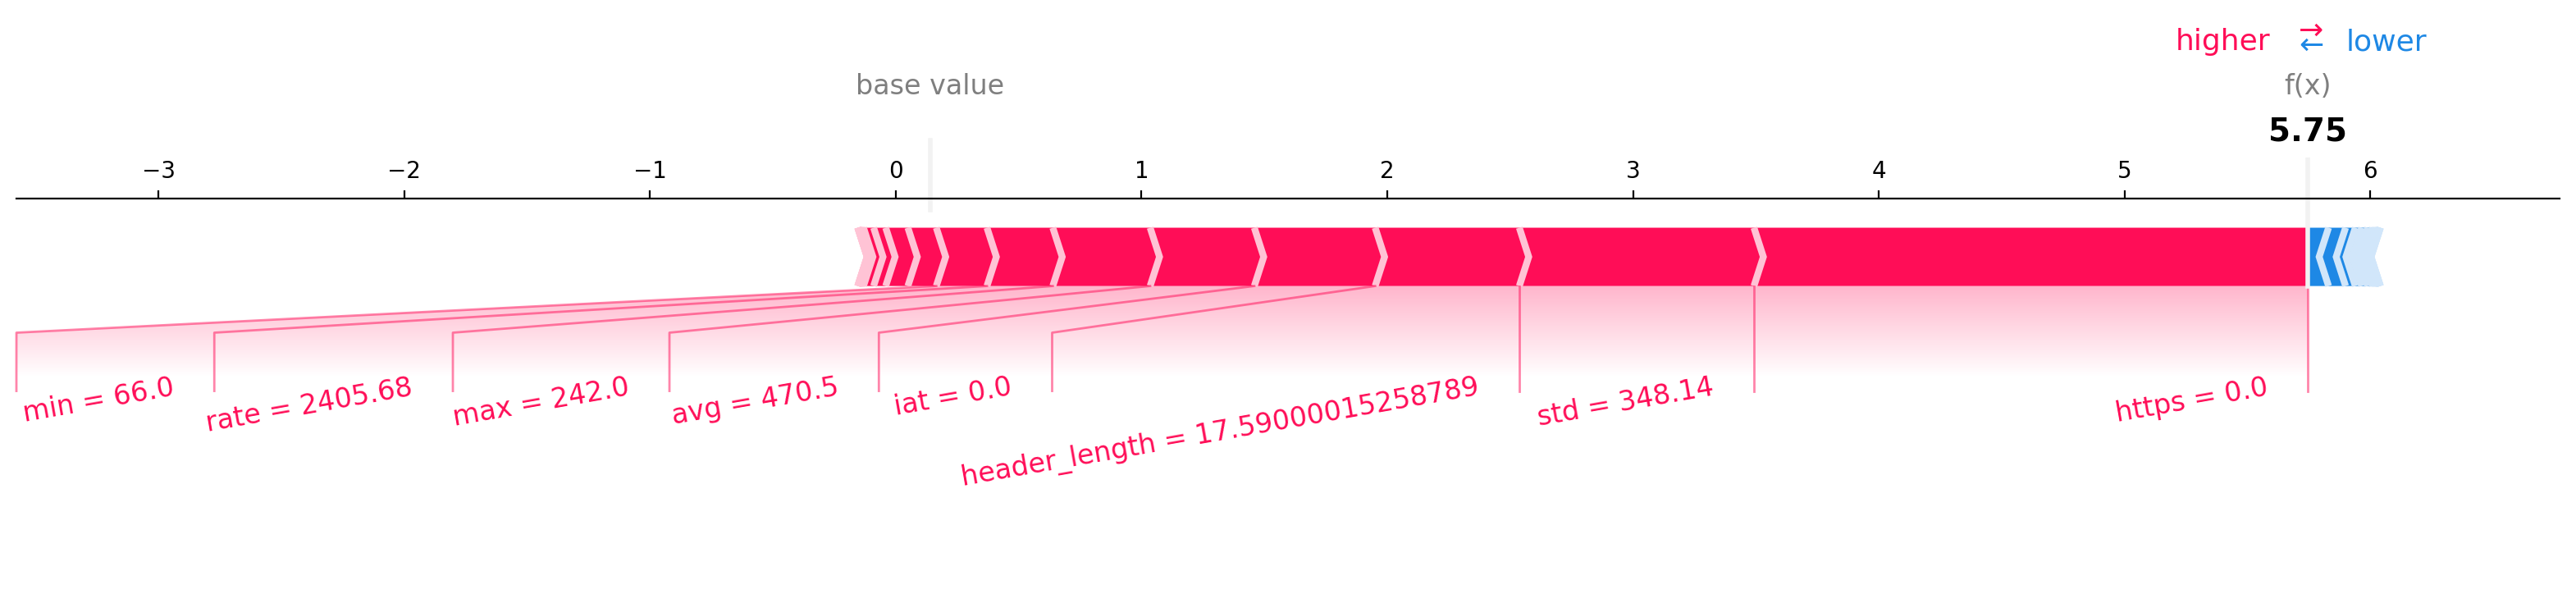

In [45]:
for idx in misclassified_indices_class1:
    shap.initjs()
    shap.force_plot(shap_explainer_binary.expected_value, shap_values_binary[idx], X_binary_test.iloc[idx], matplotlib=True, text_rotation=10)

> Instâncias na fronteira de decisão

Índice 242,602 - Predição: 0, Real: 1 → ❌ Errada


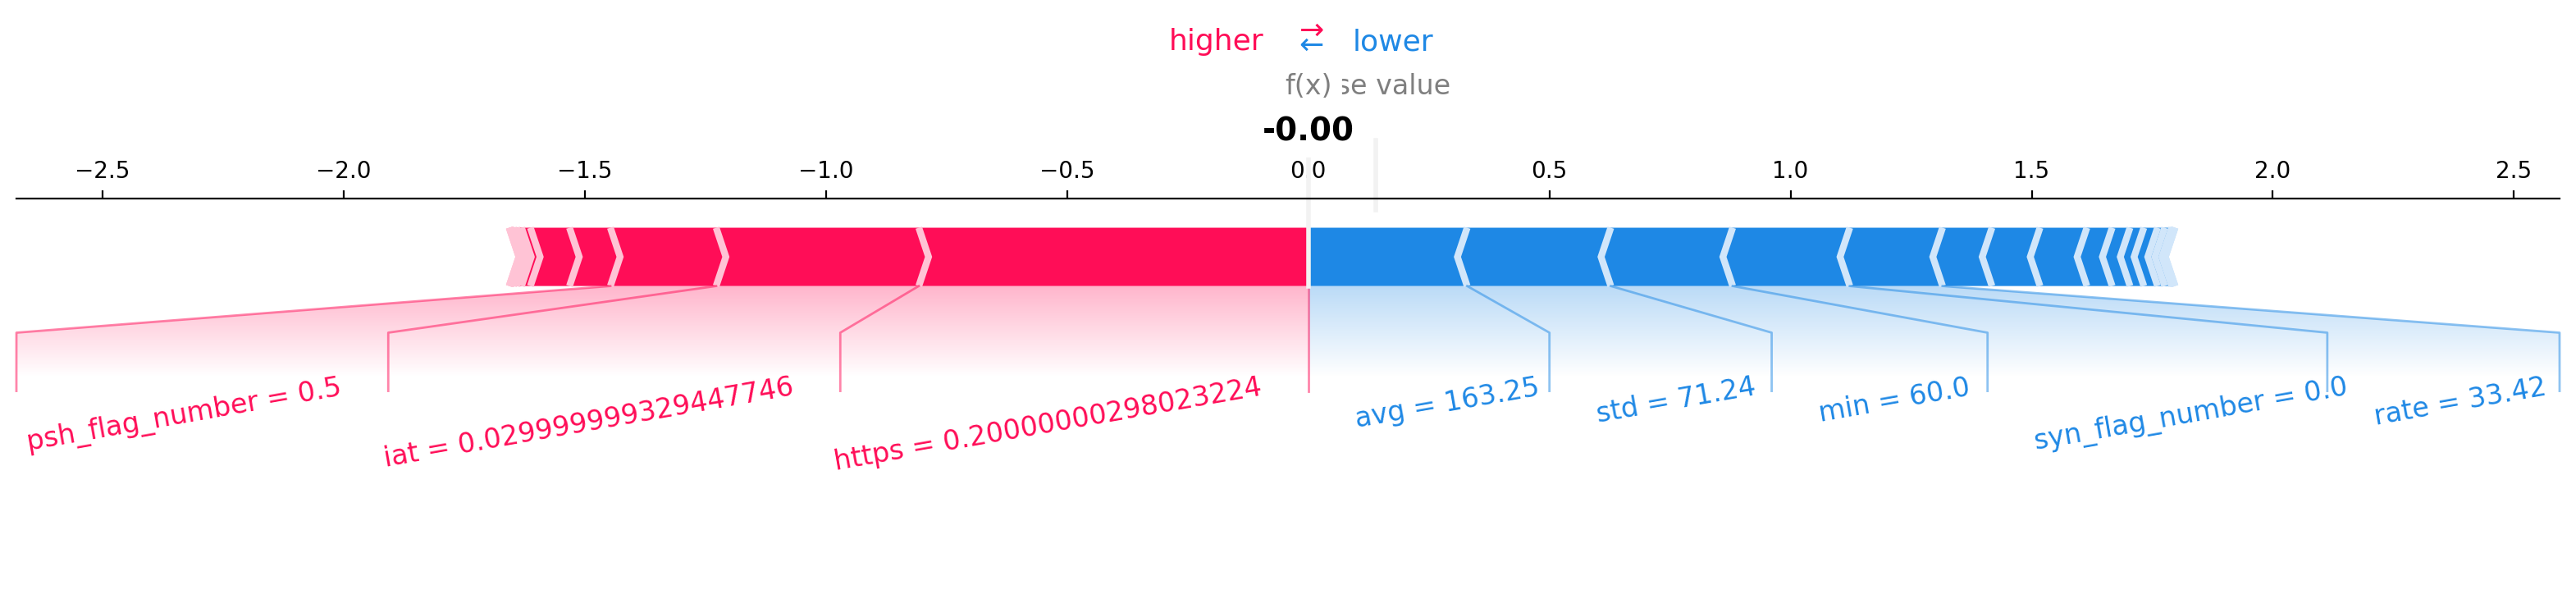

Índice 158,076 - Predição: 0, Real: 1 → ❌ Errada


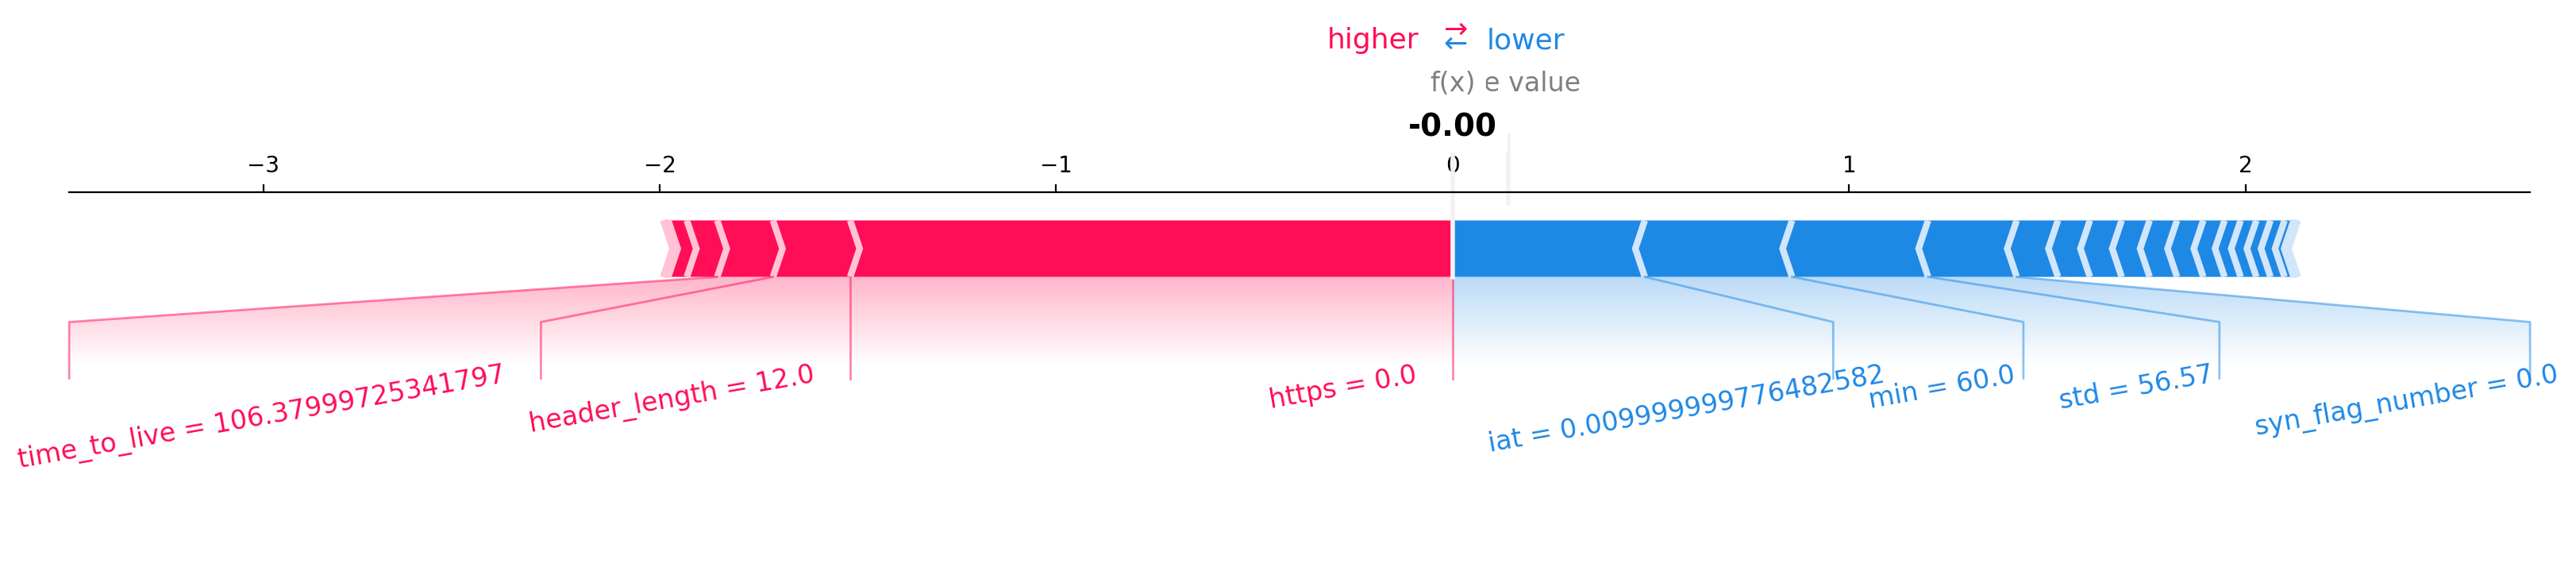

In [46]:
for idx in boundary_indices_class0:
    predicted_label = (binary_model.predict_proba(X_binary_test.iloc[[idx]])[:, 1] >= 0.5).astype(int)[0]
    true_label = y_binary_test.iloc[idx]
    classification_status = "✅ Correta" if predicted_label == true_label else "❌ Errada"
    print(f"Índice {idx:,} - Predição: {predicted_label}, Real: {true_label} → {classification_status}")

    shap.initjs()
    shap.force_plot(shap_explainer_binary.expected_value, shap_values_binary[idx], X_binary_test.iloc[idx], matplotlib=True, text_rotation=10)

Índice 418,143 - Predição: 0, Real: 0 → ✅ Correta


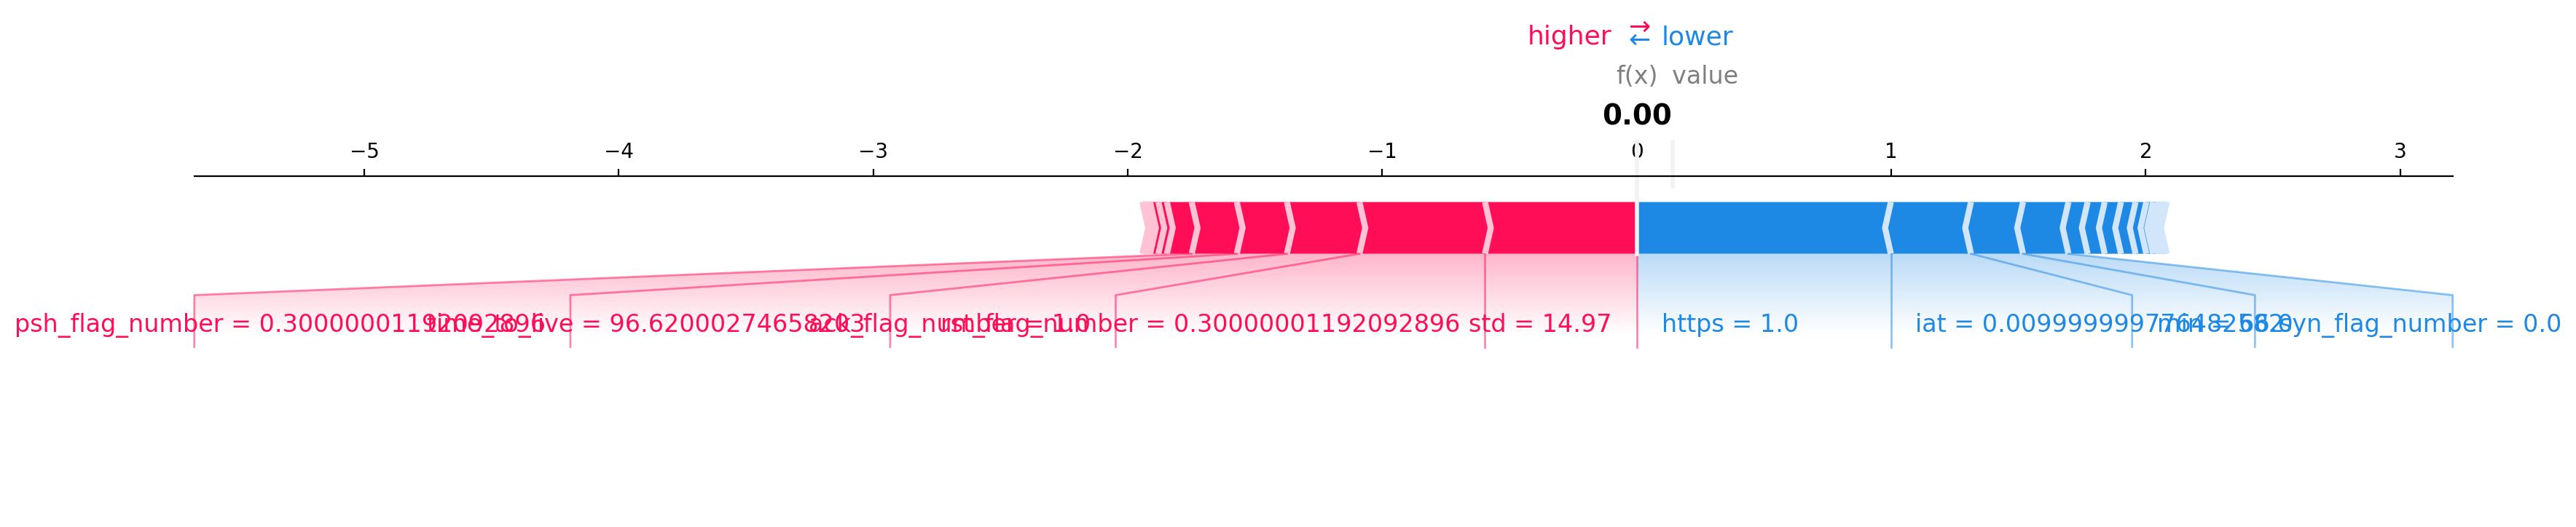

Índice 570,319 - Predição: 1, Real: 0 → ❌ Errada


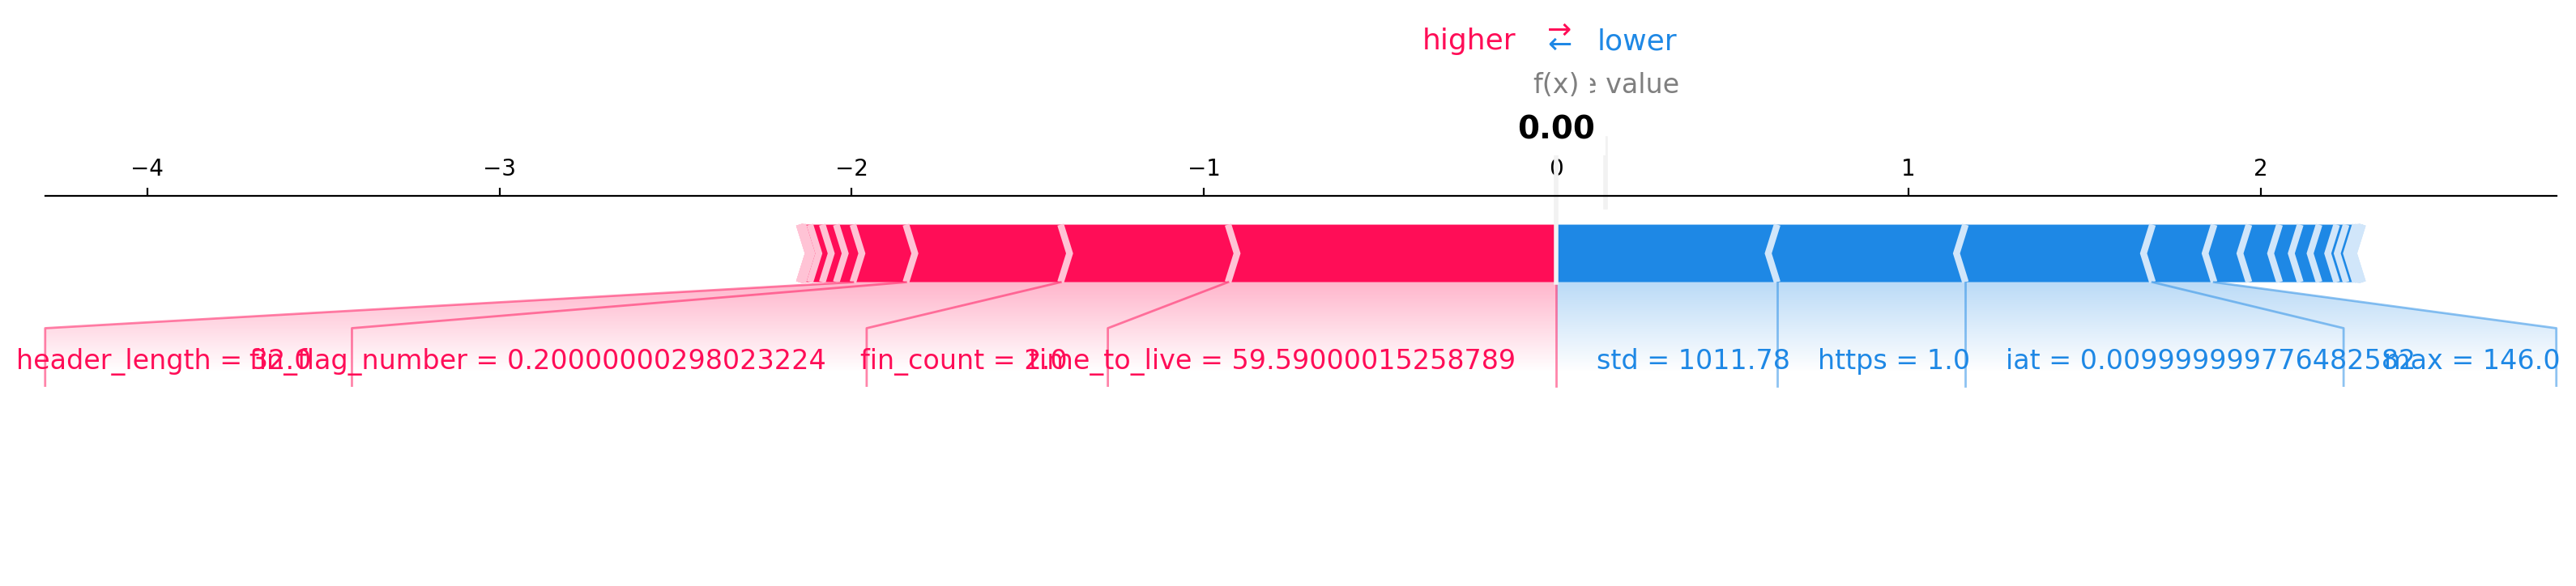

In [47]:
for idx in boundary_indices_class1:
    predicted_label = (binary_model.predict_proba(X_binary_test.iloc[[idx]])[:, 1] >= 0.5).astype(int)[0]
    true_label = y_binary_test.iloc[idx]
    classification_status = "✅ Correta" if predicted_label == true_label else "❌ Errada"
    print(f"Índice {idx:,} - Predição: {predicted_label}, Real: {true_label} → {classification_status}")

    shap.initjs()
    shap.force_plot(shap_explainer_binary.expected_value, shap_values_binary[idx], X_binary_test.iloc[idx], matplotlib=True)

#### Waterfall

> Piores Classificações

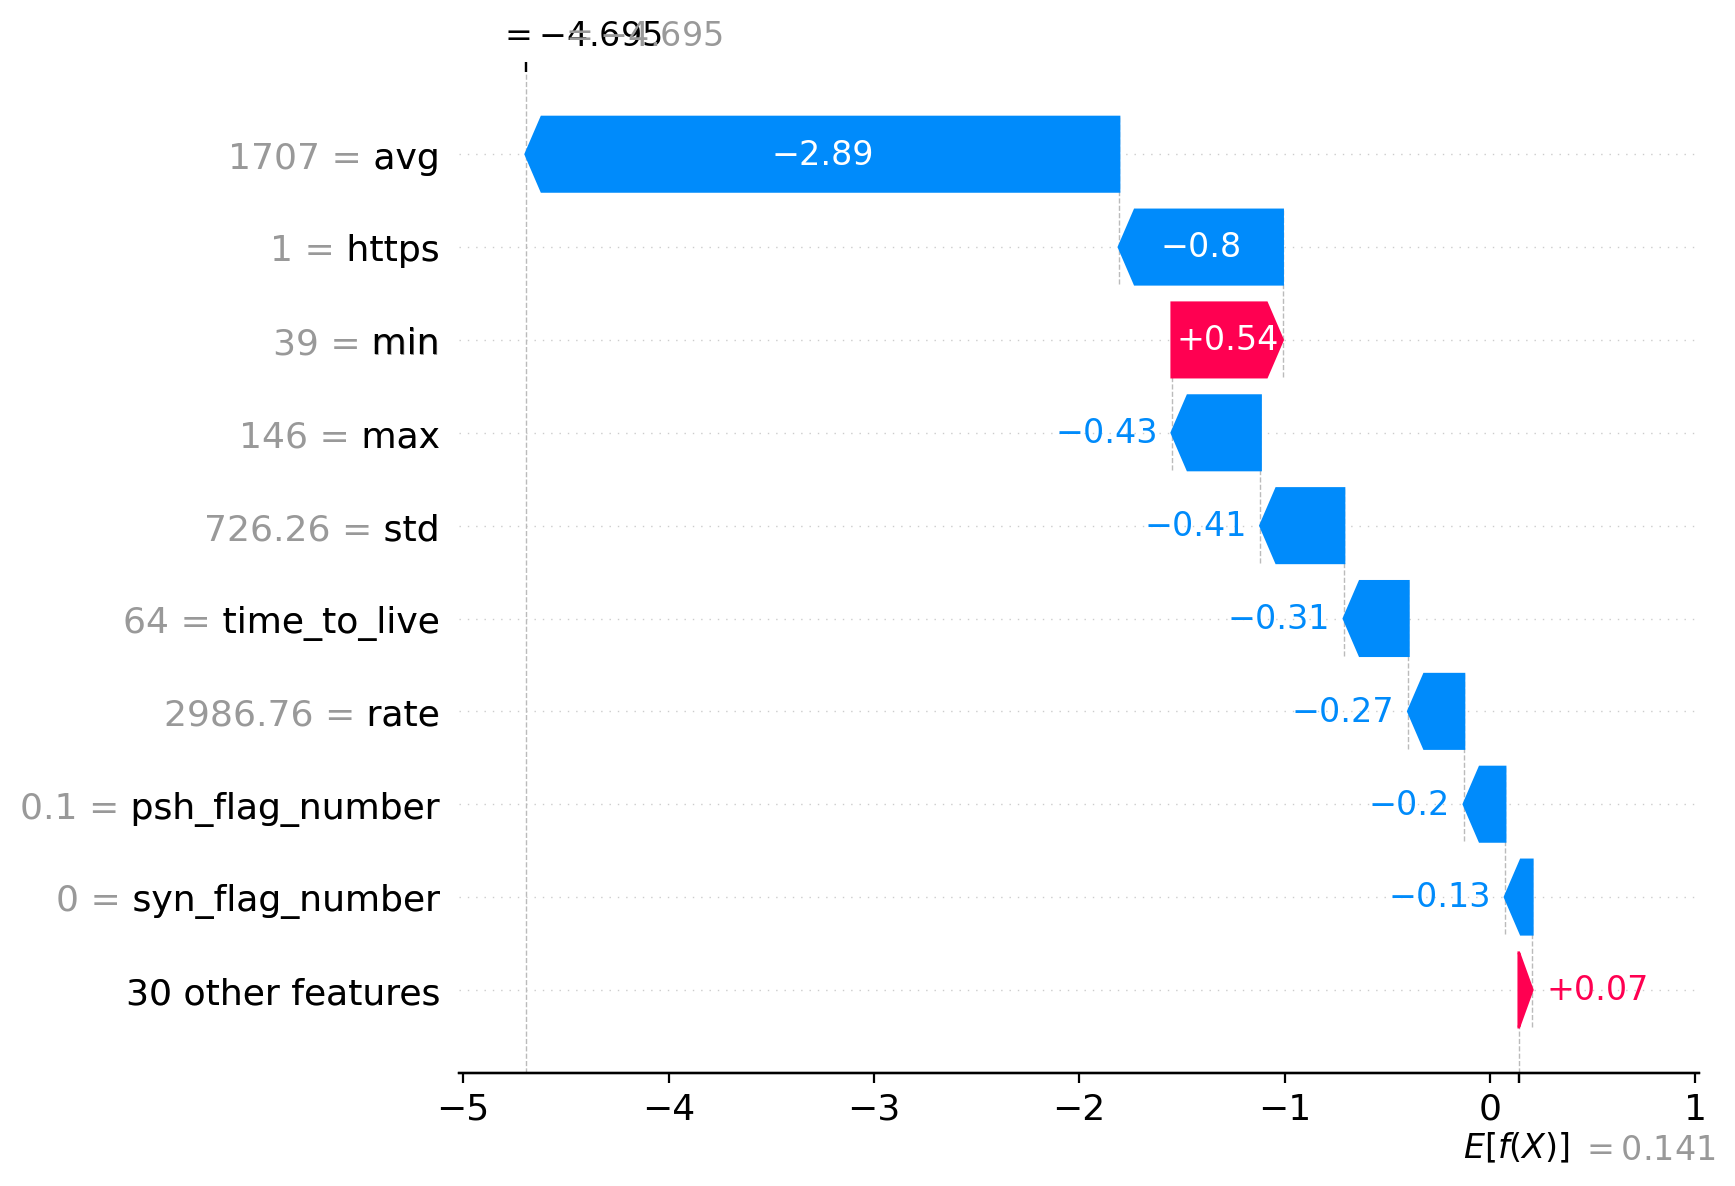

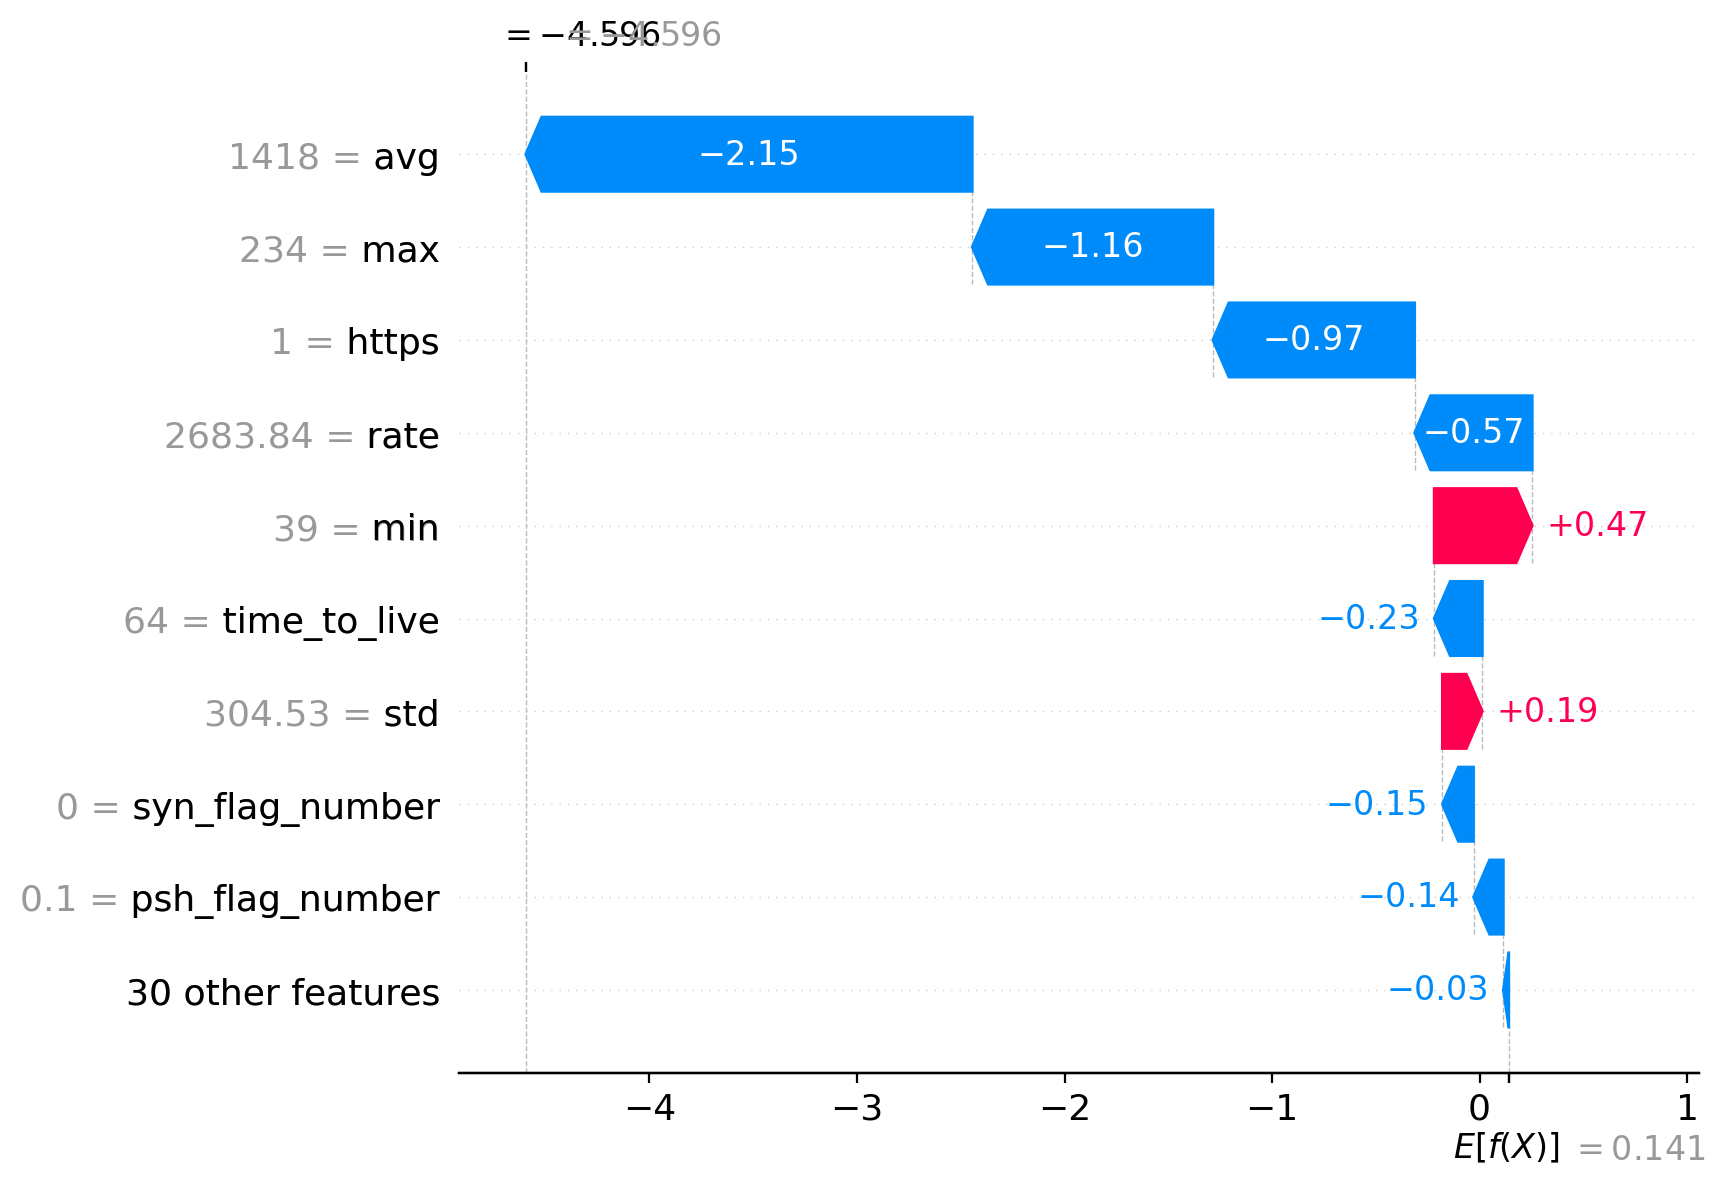

In [48]:
for idx in misclassified_indices_class0:
    shap.waterfall_plot(shap.Explanation(values=shap_values_binary[idx],
                                       base_values=shap_explainer_binary.expected_value,
                                       data=X_binary_test.iloc[idx]),
                       )

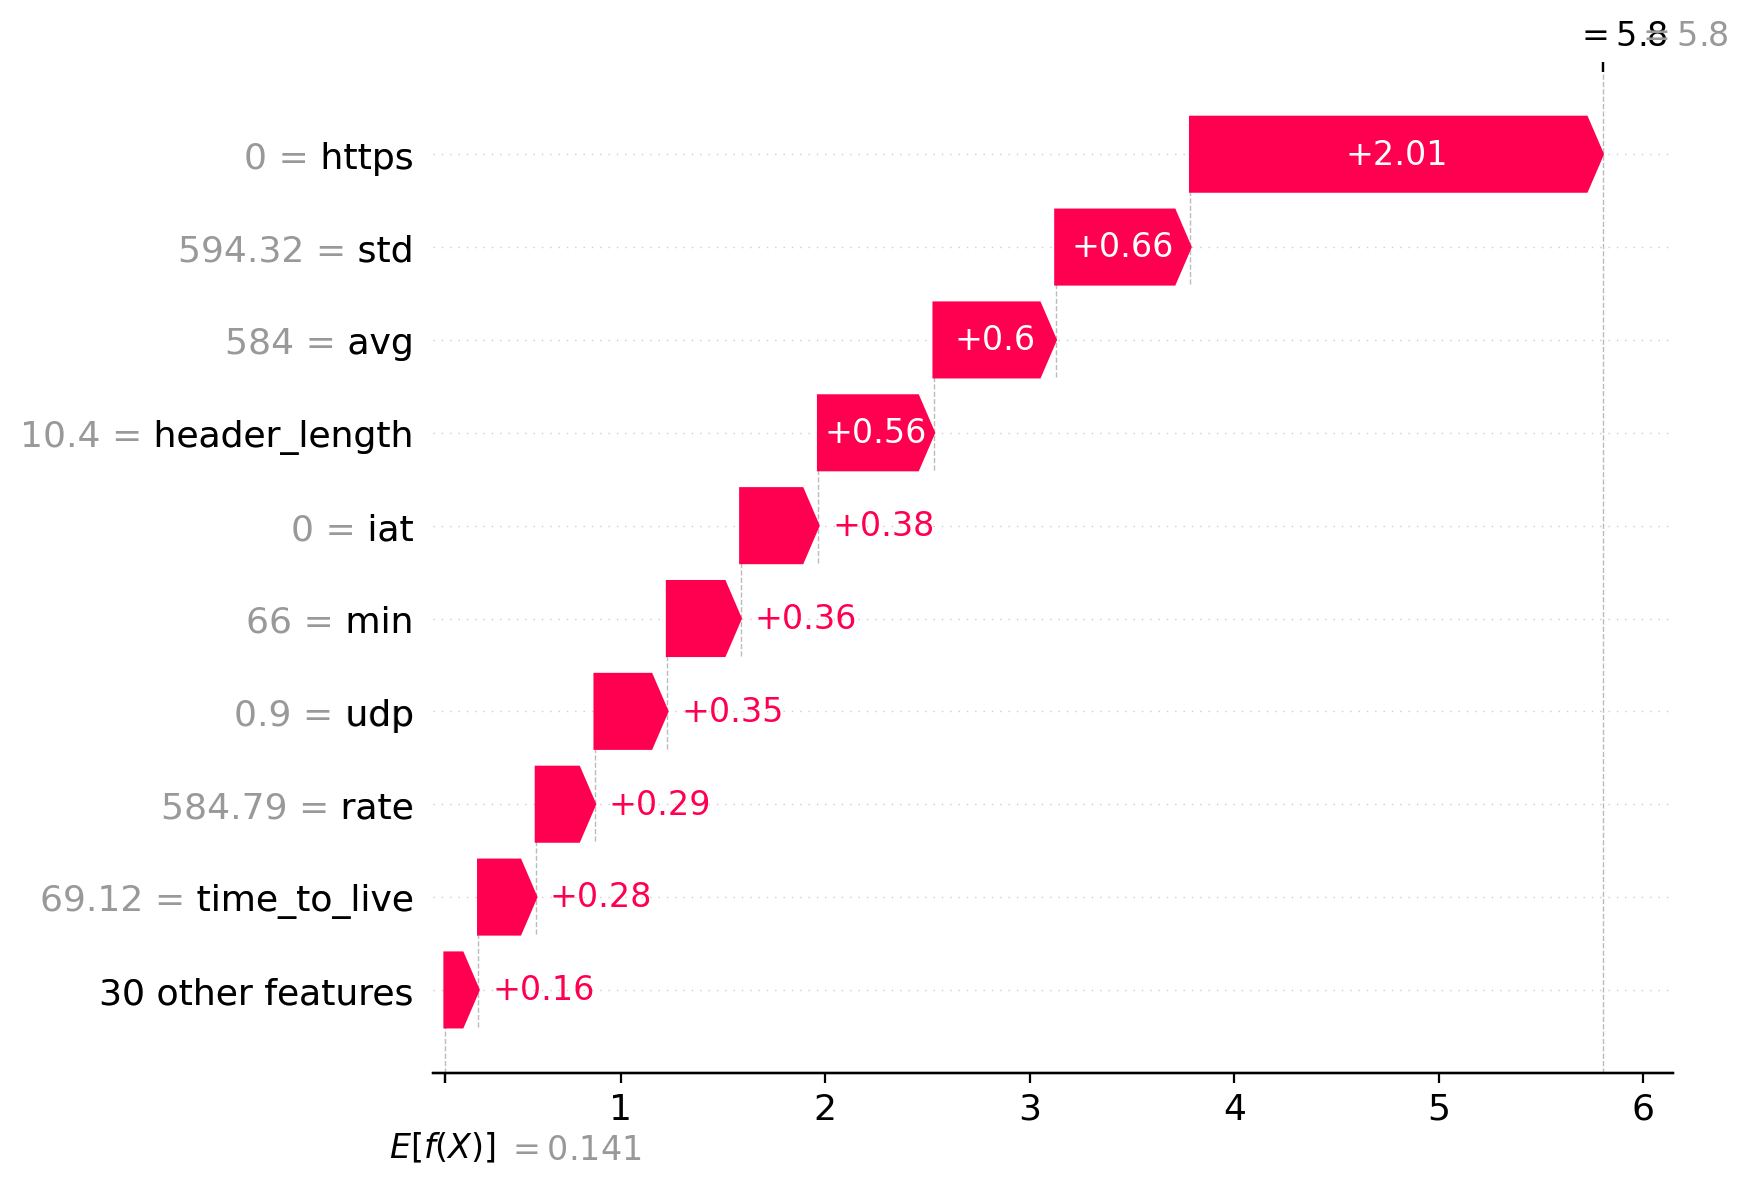

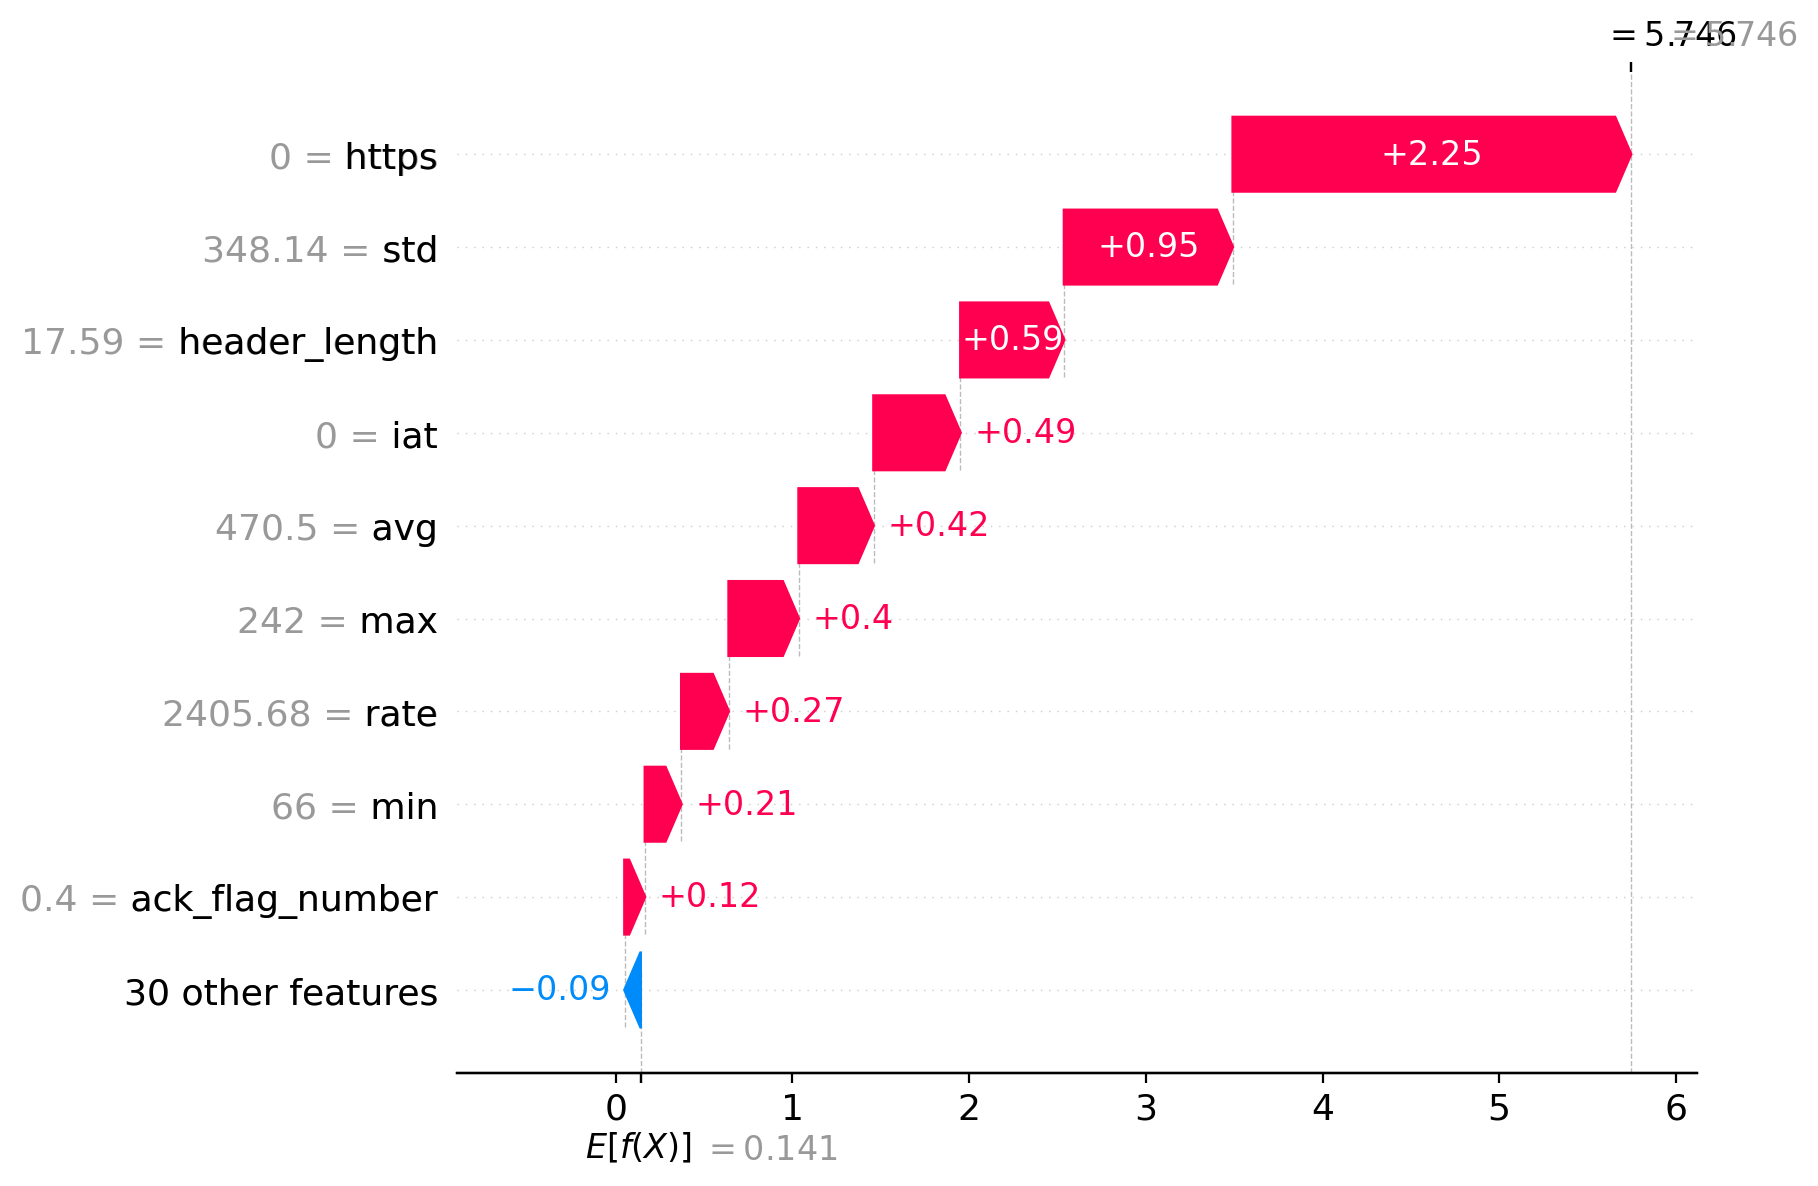

In [49]:
for idx in misclassified_indices_class1:
    shap.waterfall_plot(shap.Explanation(values=shap_values_binary[idx],
                                       base_values=shap_explainer_binary.expected_value,
                                       data=X_binary_test.iloc[idx]))

> Instâncias na fronteira de decisão

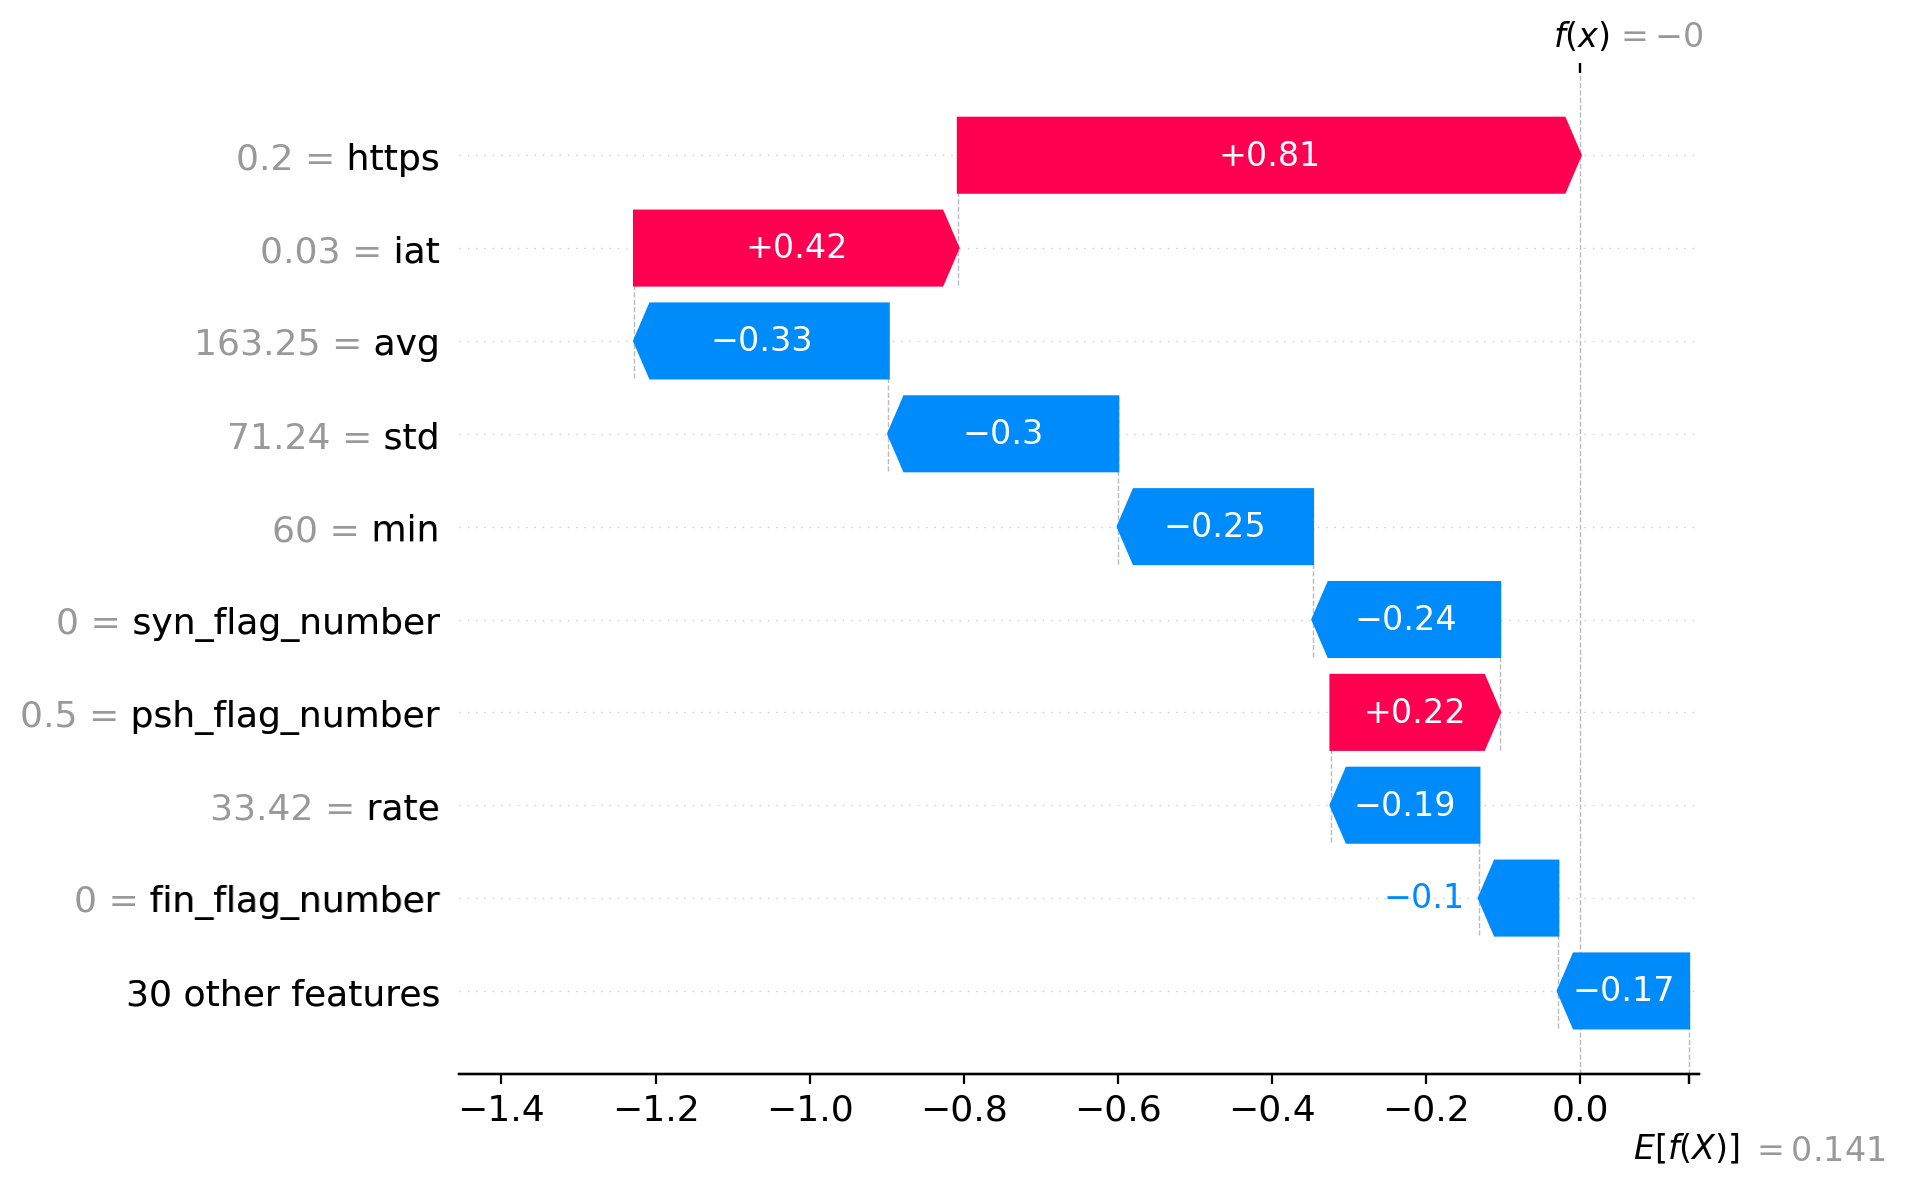

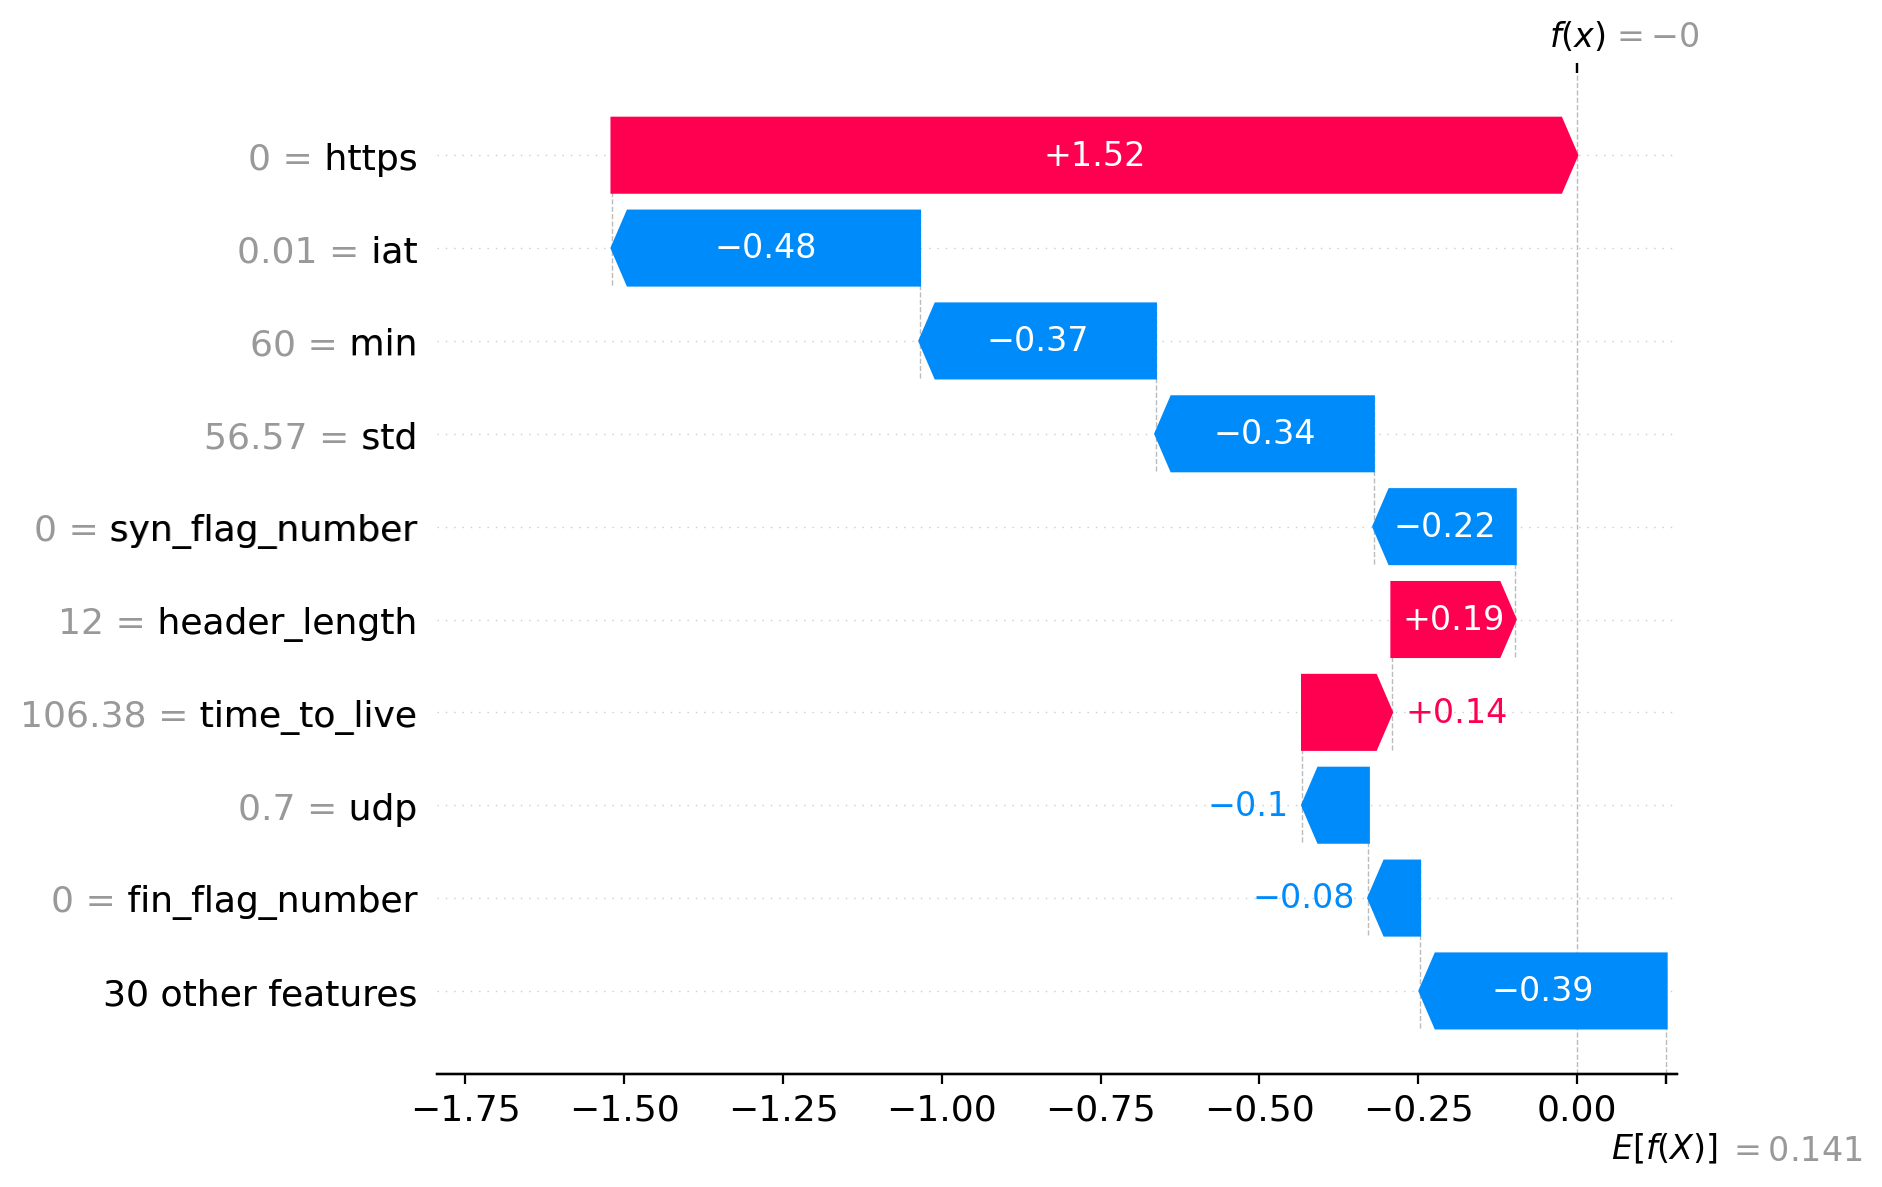

In [50]:
for idx in boundary_indices_class0:
    shap.waterfall_plot(shap.Explanation(values=shap_values_binary[idx],
                                       base_values=shap_explainer_binary.expected_value,
                                       data=X_binary_test.iloc[idx]))

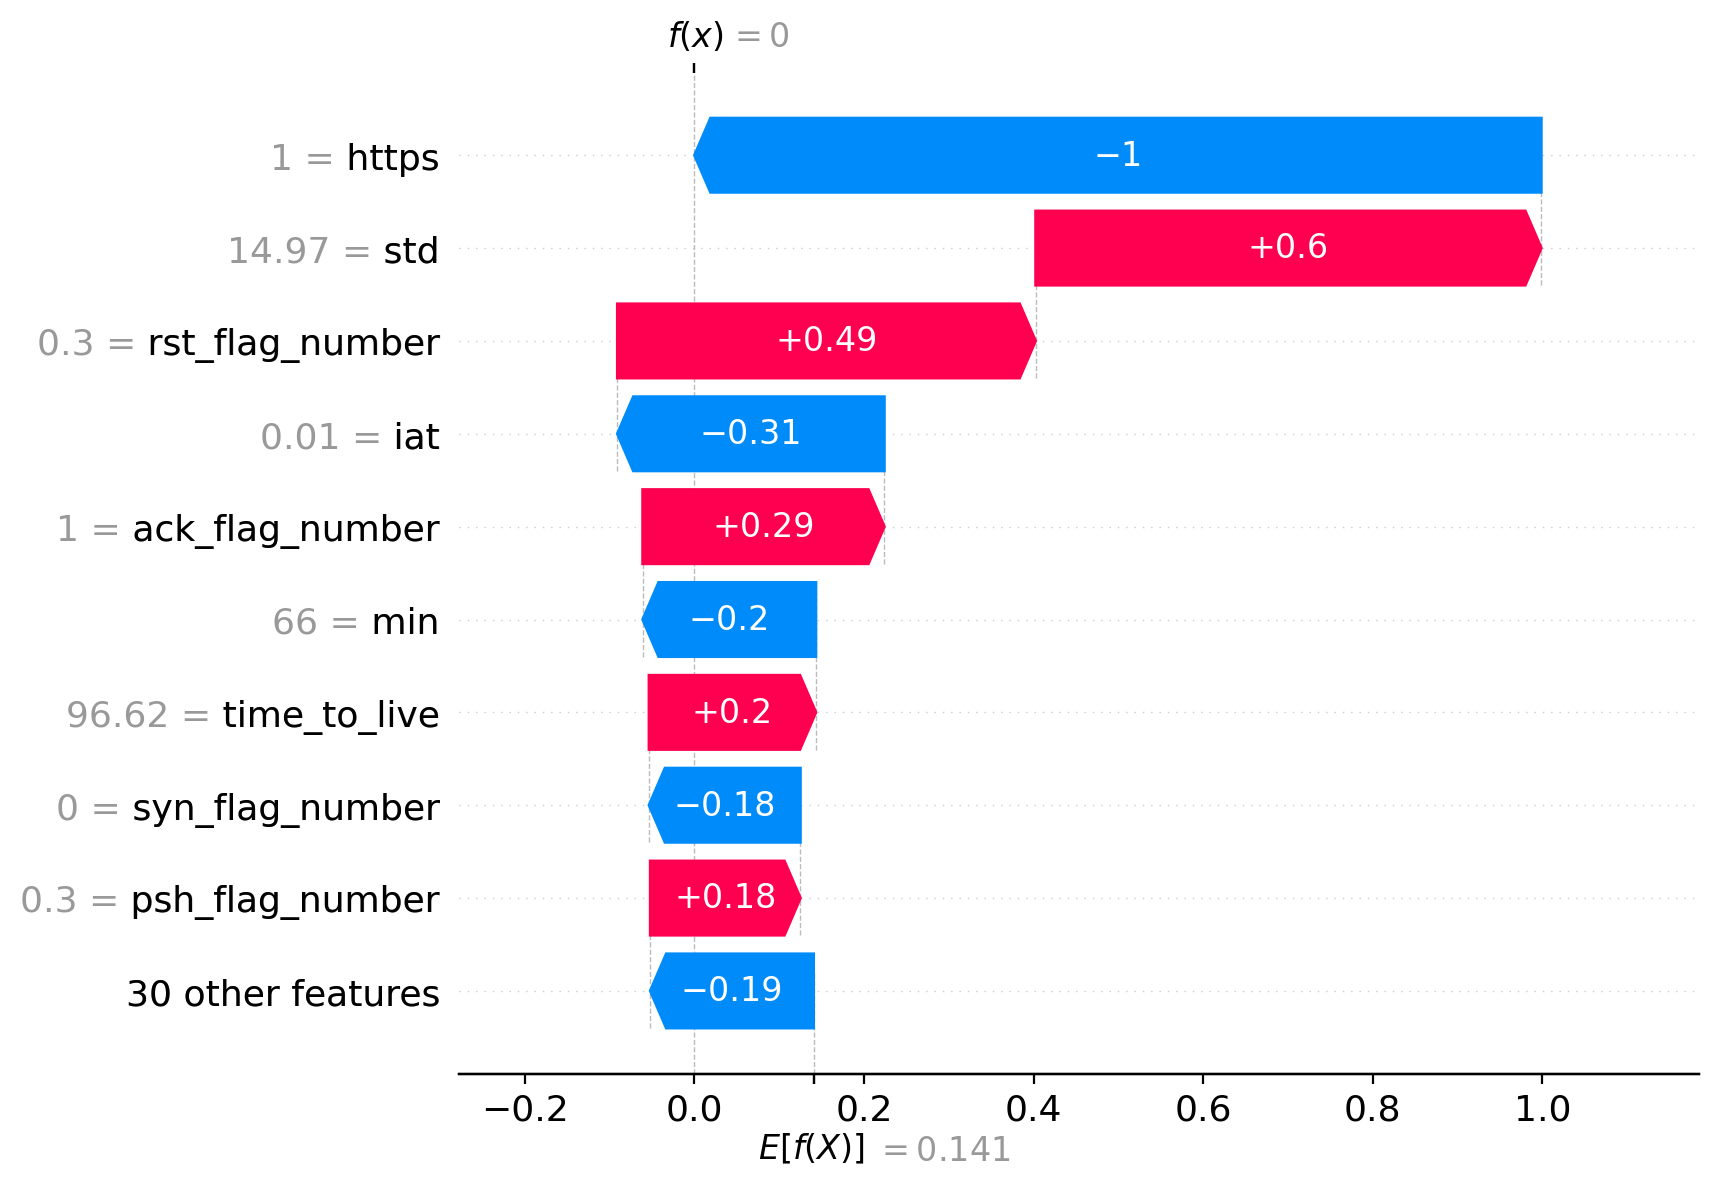

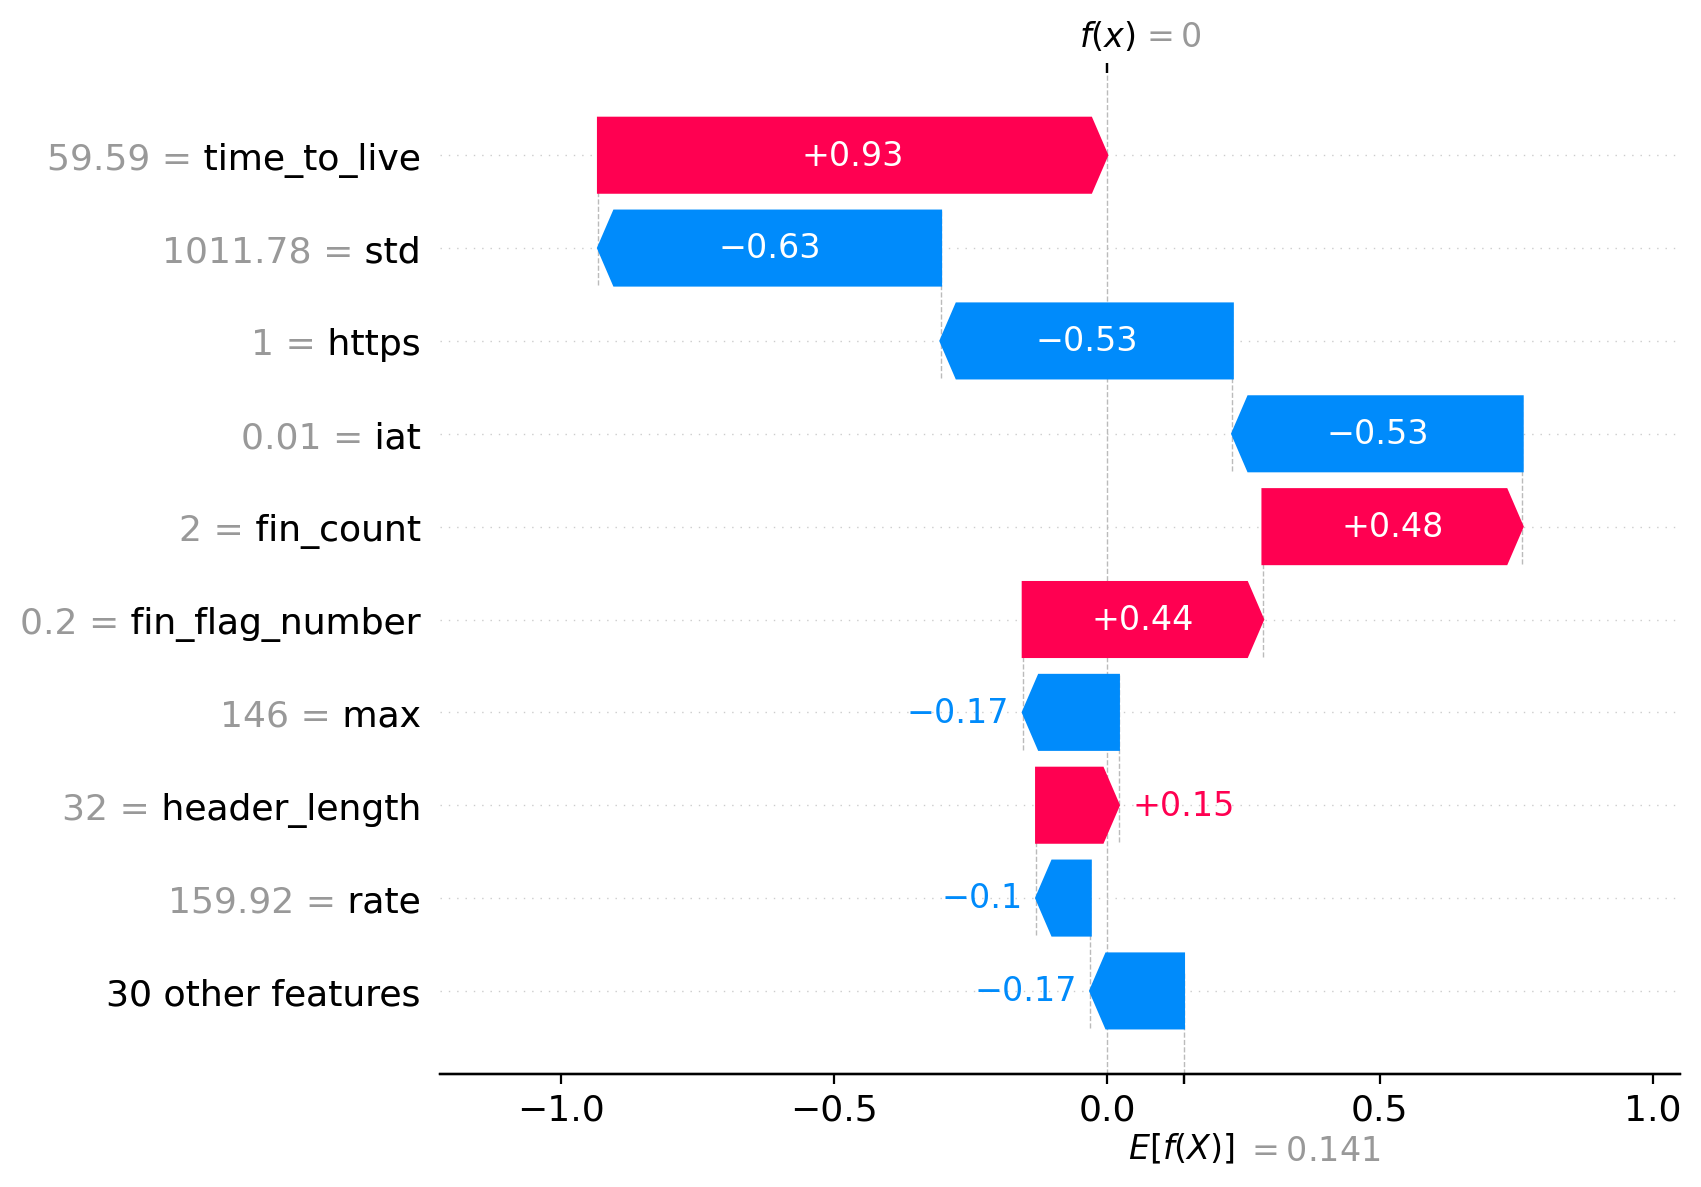

In [51]:
for idx in boundary_indices_class1:
    shap.waterfall_plot(shap.Explanation(values=shap_values_binary[idx],
                                       base_values=shap_explainer_binary.expected_value,
                                       data=X_binary_test.iloc[idx]))

---

## Explicações Multi-Classe

Contando com tráfego normal, temos 12 classes. Para as explicações, selecionamos dois ataques:

1. Maior suporte. Mais instâncias $\Rightarrow$ _Melhores_ métricas
2. Menor suporte. Menos intâncias $\Rightarrow$ _Piores_ métricas

> **_Lembrete:_** O `random_state=42` garante que a separação seja a mesma de antes

In [54]:
df_combined = pd.read_pickle('./pickles/df_combined.pkl')
X_multi = df_combined.drop(columns=['label'])
y_multi = df_combined['label']

X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)

In [55]:
y_multi_test.value_counts()

label
benign                    329438
vulnerability_scan        112003
recon                      95153
mitm_arp_spoofing          92263
dns_spoofing               53668
dictionary_brute_force      3919
browser_hijacking           1758
command_injection           1623
sql_injection               1573
xss                         1154
backdoor_malware             965
uploading_attack             376
Name: count, dtype: int64

> Sendo assim, os ataques que serão analisados são `vulnerability_scan` e `uploading_attack`.

In [56]:
multiclass_model = joblib.load("models/model_xgb.pkl")["pipeline"]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [57]:
X_multi_test_transformed = multiclass_model.named_steps['preprocessor'].transform(X_multi_test)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.13525391e-02, 1.00000000e+01, 2.83293333e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.82189941e-02, 1.00000000e+01, 5.70645556e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.32641602e-03, 1.00000000e+01, 6.40862622e+05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.82449341e-03, 1.00000000e+01, 2.19040000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.91845703e-02, 1.00000000e+01, 6.09467778e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.34944916e-03, 1.00000000e+01, 0.00000000e+00]])

In [58]:
feature_names = multiclass_model.named_steps['preprocessor'].get_feature_names_out()

array(['cat__protocol_type_HOPOPT', 'cat__protocol_type_ICMP',
       'cat__protocol_type_IGMP', 'cat__protocol_type_TCP',
       'cat__protocol_type_UDP', 'remainder__header_length',
       'remainder__time_to_live', 'remainder__rate',
       'remainder__fin_flag_number', 'remainder__syn_flag_number',
       'remainder__rst_flag_number', 'remainder__psh_flag_number',
       'remainder__ack_flag_number', 'remainder__ece_flag_number',
       'remainder__cwr_flag_number', 'remainder__ack_count',
       'remainder__syn_count', 'remainder__fin_count',
       'remainder__rst_count', 'remainder__http', 'remainder__https',
       'remainder__dns', 'remainder__telnet', 'remainder__smtp',
       'remainder__ssh', 'remainder__irc', 'remainder__tcp',
       'remainder__udp', 'remainder__dhcp', 'remainder__arp',
       'remainder__icmp', 'remainder__igmp', 'remainder__ipv',
       'remainder__llc', 'remainder__tot_sum', 'remainder__min',
       'remainder__max', 'remainder__avg', 'remainder__std',

In [59]:
import re
clean_feature_names = [re.sub(r'^(cat__|remainder__)', '', name) for name in feature_names]
print(clean_feature_names)

['protocol_type_HOPOPT', 'protocol_type_ICMP', 'protocol_type_IGMP', 'protocol_type_TCP', 'protocol_type_UDP', 'header_length', 'time_to_live', 'rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'igmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'variance']


Precisamos recuperar os rótulos com o `LabelEncoder`

In [60]:
from sklearn.preprocessing import LabelEncoder

In [61]:
label_encoder_multi = LabelEncoder()
y_multi_train_encoded = label_encoder_multi.fit_transform(y_multi_train)
y_multi_test_encoded = label_encoder_multi.transform(y_multi_test)
le_name_mapping = dict(
    zip(label_encoder_multi.classes_,
        list(map(int, label_encoder_multi.transform(label_encoder_multi.classes_)))
))
print(le_name_mapping)

{'backdoor_malware': 0, 'benign': 1, 'browser_hijacking': 2, 'command_injection': 3, 'dictionary_brute_force': 4, 'dns_spoofing': 5, 'mitm_arp_spoofing': 6, 'recon': 7, 'sql_injection': 8, 'uploading_attack': 9, 'vulnerability_scan': 10, 'xss': 11}


> Criação do *explainer*
> 
> **_CUIDADO_**: Operação abaixo computacionalmente cara, vamos serializar para não esperar no futuro

In [ ]:
shap_explainer_multi = shap.TreeExplainer(multiclass_model.named_steps['classifier'])
shap_values_multi    = shap_explainer_multi.shap_values(X_multi_test_transformed);

In [ ]:
joblib.dump(shap_explainer_multi, './shap_explainer_multi.pkl')

In [ ]:
joblib.dump(shap_values_multi, './shap_values_multi.pkl')

### Importância Global

Carregando os objetos salvos:

In [62]:
shap_explainer_multi = joblib.load('./shap_explainer_multi.pkl')
shap_values_multi    = joblib.load('./shap_values_multi.pkl');

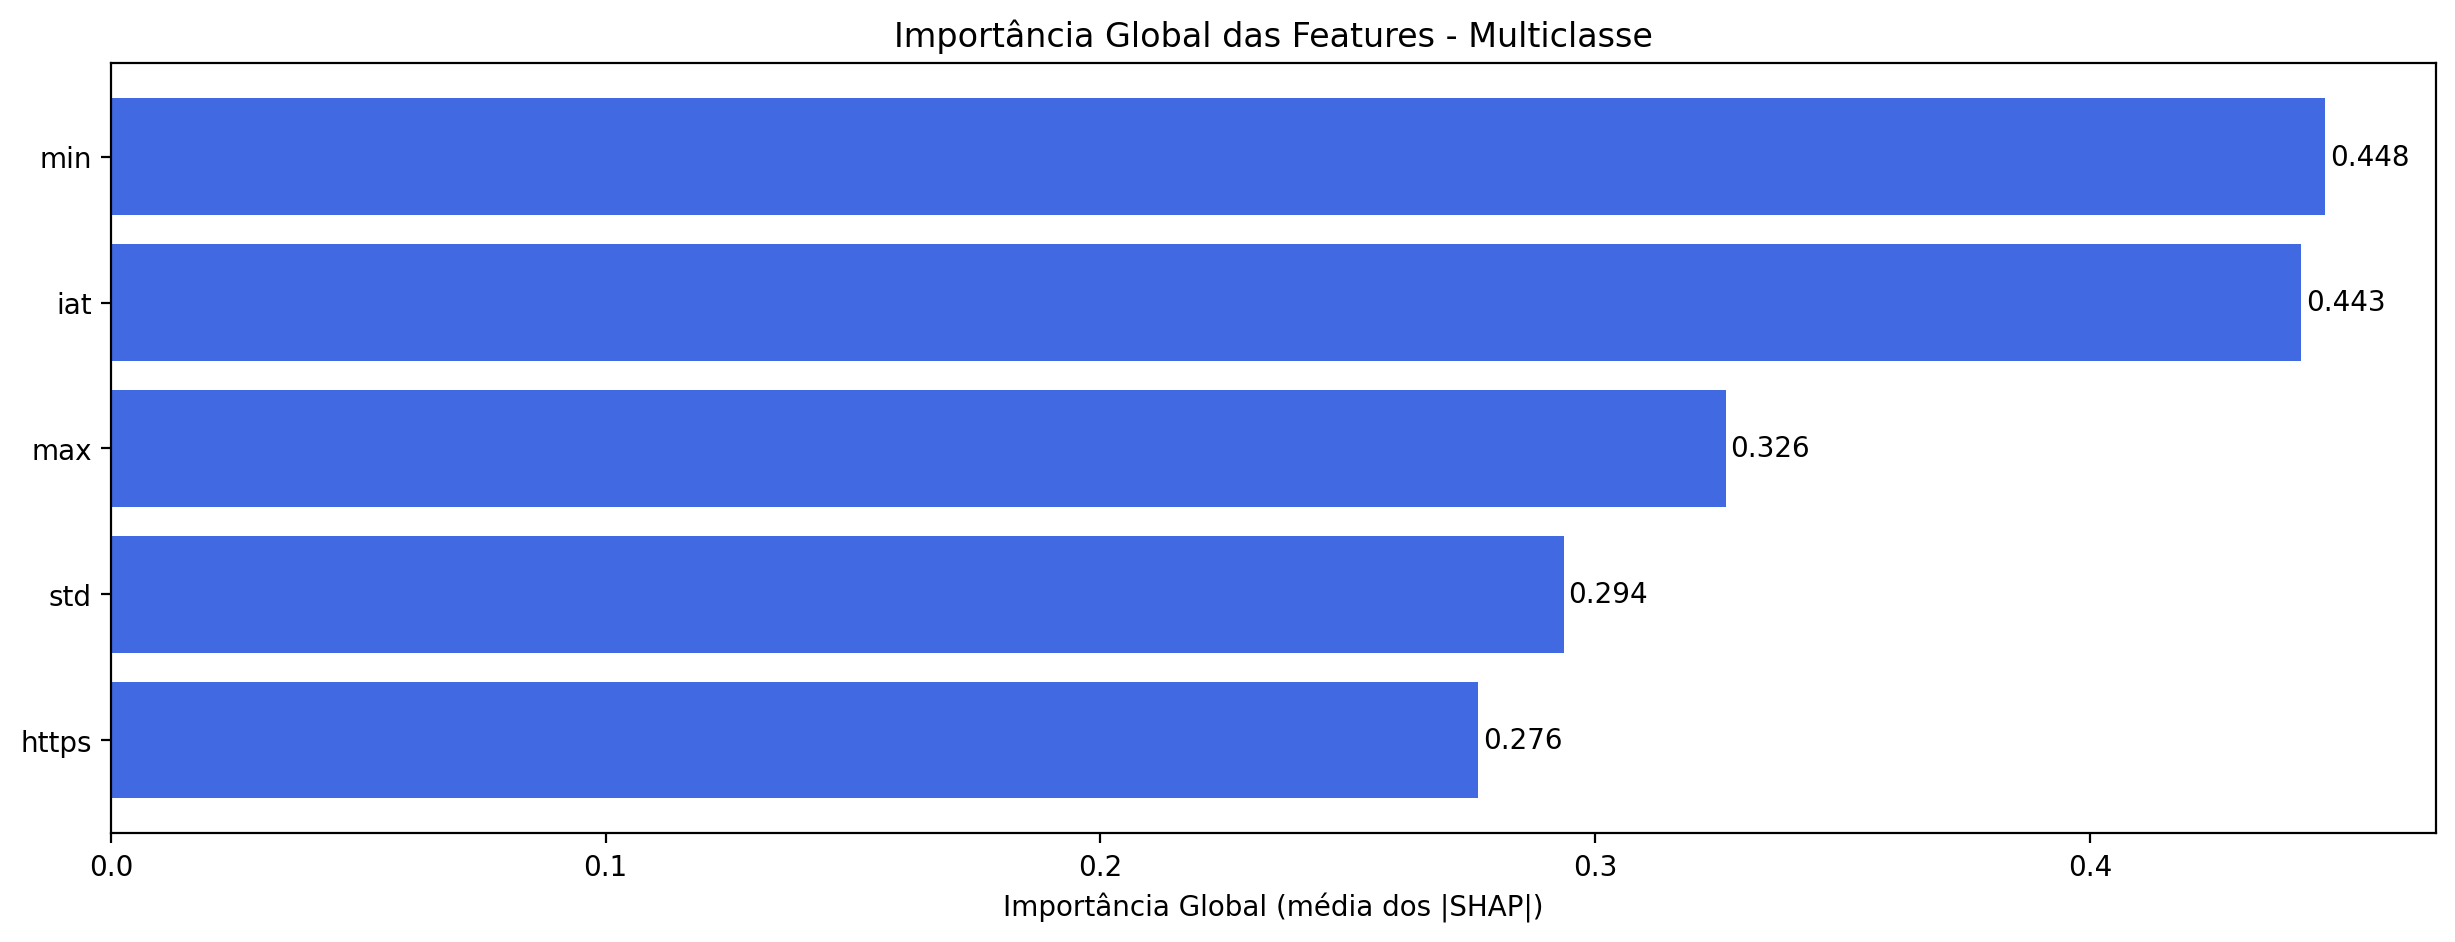

In [68]:
# Converter a lista de arrays para um array 3D: (n_amostras, n_features, n_classes)
shap_values_array = np.array(shap_values_multi)
# Calcular a média dos valores absolutos de SHAP para cada feature agregando todas as classes
global_importance = np.mean(np.abs(shap_values_array), axis=(0, 2))
# Ordenar as importâncias e pegar o top 5
indices = np.argsort(global_importance)[-5:]
# Criar gráfico
plt.figure(figsize=(15, 5))
plt.barh(range(len(indices)), global_importance[indices], color="royalblue")
# Adicionar rótulos às barras
for i, v in enumerate(global_importance[indices]):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center", fontsize=10)
# Adicionar informações ao plot
plt.yticks(range(len(indices)), np.array(clean_feature_names)[indices])
plt.xlabel("Importância Global (média dos |SHAP|)")
plt.title("Importância Global das Features - Multiclasse")
plt.show()

1. Para o binário, as top 5 foram: `https`, `min`, `max`, `std`, `syn_flag_number`
2. Para o multiclasse, elas são: `min`, `iat`, `max`, `std`, `https`

Novamente, se observa o grande impacto da features estatísticas (`min`, `max`, `std`), além de `https` aparecer em ambos cenários.

Summary Plot para os 2 ataques escolhidos

In [64]:
print(X_multi_test_transformed.shape)
print(shap_values_multi.shape)

(693893, 43)
(693893, 43, 12)


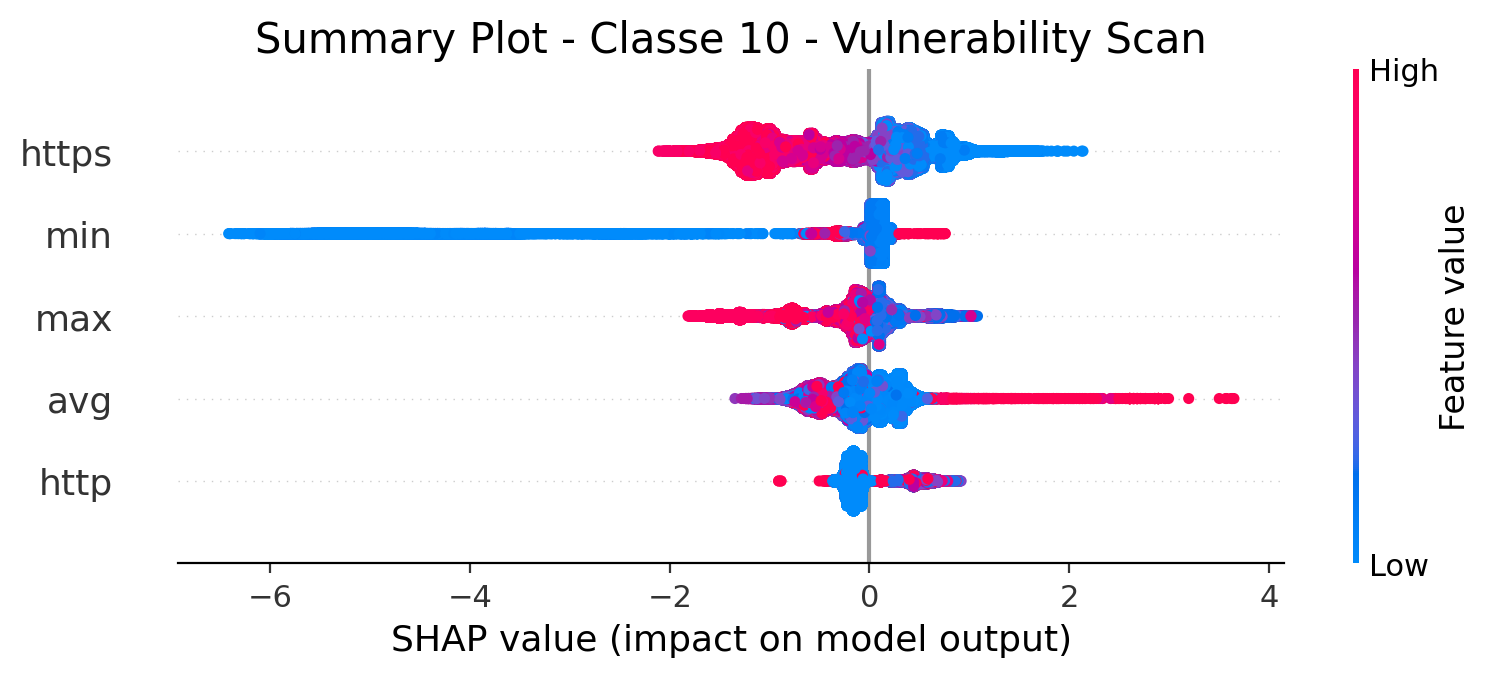

In [65]:
plt.figure(figsize=(15, 9))
shap.summary_plot(
    shap_values_multi[:, :, 10],
    X_multi_test_transformed,
    feature_names=clean_feature_names,
    max_display=5,
    show=False # Não mostrar automaticamente para poder customizar
)
plt.title("Summary Plot - Classe 10 - Vulnerability Scan", fontsize=15)
plt.tight_layout()
plt.show()

1. `https`, `min` e `avg` são as de maior peso em influência. Especialmente `min`.

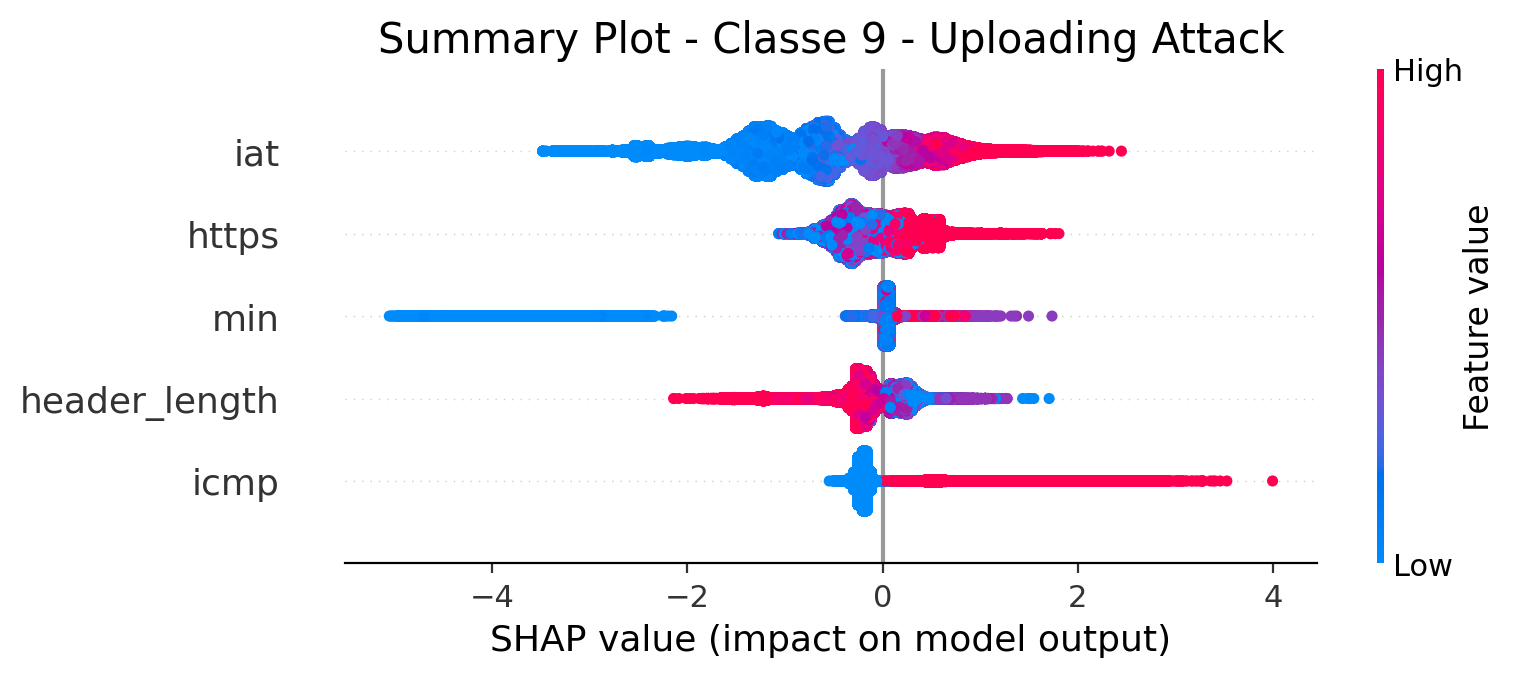

In [66]:
plt.figure(figsize=(15, 9))
shap.summary_plot(
    shap_values_multi[:, :, 9],
    X_multi_test_transformed,
    feature_names=clean_feature_names,
    max_display=5,
    show=False # Não mostrar automaticamente para poder customizar
)
plt.title("Summary Plot - Classe 9 - Uploading Attack", fontsize=15)
plt.tight_layout()
plt.show()

1. `iat`, `min` e `icmp` são as de maior peso em influência. Especialmente `min`.

> Para o maior ataque: `https`, `min` e `avg`
>
> Para o menor ataque: `iat`, `min` e `icmp`
>
> Especialmente **min**, com $|SHAP| \geq 4$

### Seleção de Instâncias

1. Casos próximos da fronteira de decisão

2. Casos de decisão confiante porém errada

### Importância Local

In [67]:
# contexto one-vs-rest (ovr), uso de sigmoide, tratando cada classe como se fosse uma classificação binária separada
    # log_odd_base_values = list(map(float, shap_explainer_multi.expected_value))
    # proba_base_values = [round(float(1 / (1 + np.exp(-value))), 2) for value in log_odd_base_values]

# contexto sofmax, assim como definido originalmente no XGboost
# garantir que os logits (valores esperados) se convertam em uma distribuição de probabilidade
log_odds = np.array(list(map(float, shap_explainer_multi.expected_value)))
exp_values = np.exp(log_odds)
proba_base_values = np.round(exp_values / np.sum(exp_values), 4)

index_to_class = {v: k for k, v in le_name_mapping.items()}
# Definir largura máxima do nome da classe prra alinhamento
sorted_probs = sorted(zip(proba_base_values, index_to_class.values()))
# Imprimir os resultados ordenados
for proba, class_name in sorted_probs:
    print(f"Classe: {class_name.ljust(22)} | Probabilidade base: {proba:.2%}")

Classe: uploading_attack       | Probabilidade base: 0.07%
Classe: backdoor_malware       | Probabilidade base: 0.17%
Classe: xss                    | Probabilidade base: 0.21%
Classe: command_injection      | Probabilidade base: 0.24%
Classe: browser_hijacking      | Probabilidade base: 0.27%
Classe: sql_injection          | Probabilidade base: 0.29%
Classe: dictionary_brute_force | Probabilidade base: 0.60%
Classe: dns_spoofing           | Probabilidade base: 7.87%
Classe: mitm_arp_spoofing      | Probabilidade base: 12.89%
Classe: recon                  | Probabilidade base: 14.38%
Classe: vulnerability_scan     | Probabilidade base: 15.55%
Classe: benign                 | Probabilidade base: 47.45%


#### Force

> Perto da fronteira

> Previsões confiantes, mas erradas

#### Waterfall

> Perto da fronteira

> Previsões confiantes, mas erradas

## Fim